In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
    
'''
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.callbacks import Callback
from keras.preprocessing import sequence
from keras.utils import np_utils
'''
 
from nariflow import Variable
from nariflow import optimizer
from nariflow import GradientTape
#from nariflow import calc_gradient
from nariflow import layer
from nariflow.models import Model
from nariflow import functions as f
from nariflow.core import elementary_function as ef
from nariflow.core import shape_function as sf

import tensorflow as tf
from tensorflow.python.framework import function
import math
 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score

#import lightgbm as lgb
 
import scipy

#import statsmodels.api
#import statsmodels as sm
 
import copy
import random
import time
from time import sleep

import re
import os

import networkx as nx

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_4312\3510566465.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
os.listdir("data")

['179502b7cf14f003d.png',
 'dangjin_fcst_data.csv',
 'dangjin_obs_data.csv',
 'energy.csv',
 'obs',
 'OBS_ASOS_TIM_20210509142735.csv',
 'OBS_ASOS_TIM_20210509143013.csv',
 'OBS_ASOS_TIM_20210509143059.csv',
 'OBS_ASOS_TIM_20210525163946.csv',
 'OBS_ASOS_TIM_20210525164100.csv',
 'OBS_ASOS_TIM_20210525164127.csv',
 'OBS_ASOS_TIM_20210526161235.csv',
 'OBS_ASOS_TIM_20210526161318.csv',
 'OBS_ASOS_TIM_20210526161340.csv',
 'OBS_ASOS_TIM_20210526161401.csv',
 'OBS_ASOS_TIM_20210526161419.csv',
 'OBS_ASOS_TIM_20210526161438.csv',
 'sample_submission.csv',
 'site_info.csv',
 'ulsan_fcst_data.csv',
 'ulsan_obs_data.csv',
 'weather',
 '석문면_강수형태_201801_201812.csv',
 '석문면_강수형태_201901_201912.csv',
 '석문면_강수형태_202001_202012.csv',
 '석문면_강수형태_202101_202102.csv',
 '석문면_강수확률_201801_201812.csv',
 '석문면_강수확률_201901_201912.csv',
 '석문면_강수확률_202001_202012.csv',
 '석문면_강수확률_202101_202102.csv',
 '선암동_강수형태_201801_201812.csv',
 '선암동_강수형태_201901_201912.csv',
 '선암동_강수형태_202001_202012.csv',
 '선암동_강수형태_202101_202102

# 1. Data Load

In [4]:
dangjin_fcst = pd.read_csv("data/dangjin_fcst_data.csv")
dangjin_obs = pd.read_csv("data/dangjin_obs_data.csv")
energy = pd.read_csv("data/energy.csv")
site_info = pd.read_csv("data/site_info.csv")
ulsan_fcst = pd.read_csv("data/ulsan_fcst_data.csv")
ulsan_obs = pd.read_csv("data/ulsan_obs_data.csv")

## 1) 데이터 준비

### (1) Forecast Time 변환

In [5]:
dangjin_fcst["forecast"] = pd.to_datetime(dangjin_fcst["Forecast time"]) + dangjin_fcst["forecast"].apply(
    lambda x : pd.Timedelta(x, unit = "H"))

In [6]:
ulsan_fcst["forecast"] = pd.to_datetime(ulsan_fcst["Forecast time"]) + ulsan_fcst["forecast"].apply(
    lambda x : pd.Timedelta(x, unit = "H"))

# 2. EDA

## 1) 기초 통계 및 결측, 이상치 확인

### (1) 결측치

In [7]:
print(dangjin_fcst.isna().apply(lambda x : x.value_counts()))
print(dangjin_obs.isna().apply(lambda x : x.value_counts()))
print(energy.isna().apply(lambda x : x.value_counts()))
print(site_info.isna().apply(lambda x : x.value_counts()))
print(ulsan_fcst.isna().apply(lambda x : x.value_counts()))
print(ulsan_obs.isna().apply(lambda x : x.value_counts()))

       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud  
False         162208  162208  
            지점      지점명       일시  기온(°C)  풍속(m/s)  풍향(16방위)  습도(%)  전운량(10분위)
False  25626.0  25626.0  25626.0   25589    25590     25590  25591      21656
True       NaN      NaN      NaN      37       36        36     35       3970
          time  dangjin_floating  dangjin_warehouse  dangjin    ulsan
False  25632.0             25608              25584  25632.0  25632.0
True       NaN                24                 48      NaN      NaN
       Id  Capacity  Address  InstallationAngle  IncidentAngle  Latitude  \
False   4         4        4                  4              4         4   

       Longitude  
False          4  
       Forecast time  forecast  Temperature  Humidity  WindSpeed  \
False         162208    162208       162208    162208     162208   

       WindDirection   Cloud 

Forecast엔 결측치가 없고, obs엔 결측치가 소수 존재한다. Energy 결측치는 이유에 대한 탐색이 필요해보인다.

#### - Energy 결측 탐색

In [8]:
energy.loc[energy["dangjin_warehouse"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
384,2018-03-17 1:00:00,0.0,NaN,0,0
385,2018-03-17 2:00:00,0.0,NaN,0,0
386,2018-03-17 3:00:00,0.0,NaN,0,0
387,2018-03-17 4:00:00,0.0,NaN,0,0
388,2018-03-17 5:00:00,0.0,NaN,0,0
389,2018-03-17 6:00:00,0.0,NaN,0,0
390,2018-03-17 7:00:00,0.0,NaN,0,0
391,2018-03-17 8:00:00,24.0,NaN,16,13
392,2018-03-17 9:00:00,162.0,NaN,177,57
393,2018-03-17 10:00:00,363.0,NaN,348,206


In [9]:
energy.loc[energy["dangjin_floating"].isna()]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
20352,2020-06-26 1:00:00,NaN,0.0,0,0
20353,2020-06-26 2:00:00,NaN,0.0,0,0
20354,2020-06-26 3:00:00,NaN,0.0,0,0
20355,2020-06-26 4:00:00,NaN,0.0,0,0
20356,2020-06-26 5:00:00,NaN,0.0,0,0
20357,2020-06-26 6:00:00,NaN,0.0,0,0
20358,2020-06-26 7:00:00,NaN,7.0,2,7
20359,2020-06-26 8:00:00,NaN,20.0,18,50
20360,2020-06-26 9:00:00,NaN,148.0,175,161
20361,2020-06-26 10:00:00,NaN,242.0,330,170


Enegry 내부에선 상관성이 있는 변수가 없어보인다.

정확히 하루 단위로 데이터가 NA이므로, 삭제해도 무방할 것으로 판단됨

In [10]:
energy = energy.dropna().reset_index(drop = True)

#### - obs 결측 탐색

In [11]:
dangjin_obs.isna().apply(lambda x : x.value_counts())

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
False,25626.0,25626.0,25626.0,25589,25590,25590,25591,21656
True,NaN,NaN,NaN,37,36,36,35,3970


In [12]:
dangjin_fcst[dangjin_fcst["Forecast time"] == '2019-01-31 11:00:00']

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
49728,2019-01-31 11:00:00,2019-01-31 15:00:00,-1.0,40.0,9.0,328.0,4.0
49729,2019-01-31 11:00:00,2019-01-31 18:00:00,-3.0,45.0,9.2,323.0,3.0
49730,2019-01-31 11:00:00,2019-01-31 21:00:00,-3.0,50.0,10.9,320.0,3.0
49731,2019-01-31 11:00:00,2019-02-01 00:00:00,-4.0,50.0,10.1,319.0,2.0
49732,2019-01-31 11:00:00,2019-02-01 03:00:00,-2.0,60.0,8.8,320.0,3.0
49733,2019-01-31 11:00:00,2019-02-01 06:00:00,-2.0,70.0,5.9,318.0,3.0
49734,2019-01-31 11:00:00,2019-02-01 09:00:00,-2.0,70.0,2.9,252.0,3.0
49735,2019-01-31 11:00:00,2019-02-01 12:00:00,2.0,45.0,7.5,284.0,2.0
49736,2019-01-31 11:00:00,2019-02-01 15:00:00,4.0,45.0,8.1,275.0,2.0
49737,2019-01-31 11:00:00,2019-02-01 18:00:00,1.0,65.0,7.5,269.0,1.0


In [13]:
dangjin_obs[dangjin_obs["일시"].str.slice(0,10) == '2019-01-31']

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
8058,129,서산,2019-01-31 00:00,1.4,0.1,0.0,85.0,10.0
8059,129,서산,2019-01-31 01:00,1.3,0.4,0.0,87.0,10.0
8060,129,서산,2019-01-31 02:00,2.3,1.3,20.0,88.0,10.0
8061,129,서산,2019-01-31 03:00,1.8,1.0,20.0,80.0,10.0
8062,129,서산,2019-01-31 04:00,1.6,2.5,360.0,56.0,10.0
8063,129,서산,2019-01-31 05:00,1.0,1.9,360.0,51.0,10.0
8064,129,서산,2019-01-31 06:00,0.6,1.4,360.0,48.0,10.0
8065,129,서산,2019-01-31 07:00,0.3,2.9,360.0,48.0,10.0
8066,129,서산,2019-01-31 08:00,-0.3,2.4,360.0,45.0,10.0
8067,129,서산,2019-01-31 09:00,-0.6,2.7,360.0,44.0,10.0


기온, 풍속, 풍향, 습도 결측치는 서로 밀접한 연관이 있는 것으로 보인다.

활용이 불가능하므로 제외한다.

In [14]:
dangjin_obs = dangjin_obs.dropna(axis = 0, subset = ["기온(°C)","풍속(m/s)", "풍향(16방위)", "습도(%)"]).reset_index(drop = True)

### - 전운량 결측 탐색

In [15]:
dangjin_obs["전운량(10분위)"].isna().value_counts()

False    21618
True      3970
Name: 전운량(10분위), dtype: int64

In [16]:
dangjin_obs = dangjin_obs.rename(columns = {"일시" : "forecast"})

dangjin_obs["forecast"] = pd.to_datetime(dangjin_obs["forecast"])

In [17]:
dangjin_obs["date"] = dangjin_obs["forecast"].dt.date
dangjin_obs["hour"] = dangjin_obs["date"].astype("str") + " " + dangjin_obs["forecast"].dt.hour.astype("str")

<AxesSubplot:>

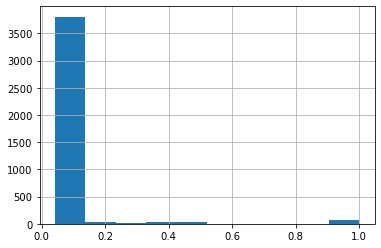

In [18]:
# 하루 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("date").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

최초 예상으로는 전운량이 Na인 경우 하루 전체가 다 그럴것이라는 가설을 세웠지만

그 가설은 사실이 아닌것으로 판명되었다.

<AxesSubplot:>

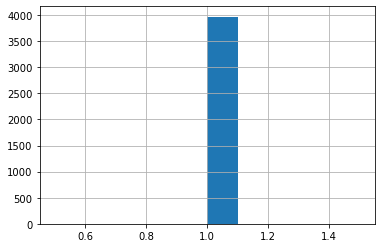

In [19]:
# 시간 중 전운량이 NA인 비율

k = dangjin_obs[dangjin_obs["전운량(10분위)"].isna()].groupby("hour").apply(lambda x : x["전운량(10분위)"].isna() / len(x))

k.hist()

## 2) 파생 변수 생성 전략 탐색

### (1) obs의 전운량과 fcst의 cloud간 비교 

#### - 데이터 Merge

In [20]:
result = pd.merge(dangjin_obs, dangjin_fcst, on = "forecast", how = "left")

#### - 상관계수

In [21]:
result[["Cloud","전운량(10분위)"]].corr()

,Cloud,전운량(10분위)
Cloud,1.00000,0.54449
전운량(10분위),0.54449,1.00000


상관도가 생각보다 낮다. 예측과 실제값 사이에 괴리감이 큰 것으로 보인다.

#### - 오차값(잔차) 확인

잔차를 확인하면 이를 이용하여 예측값에서 실제 정답값을 유사하게라도 보정할 수 있지 않을까?

히스토그램을 그려 잔차가 정규분포를 따르는지 확인하고, 실제 정규성 검정을 수행해본다.

(array([ 4267., 10232., 22770., 29142.,  9112.,  7611., 13987., 23917.,
         5448.,  6340.]),
 array([-9. , -7.7, -6.4, -5.1, -3.8, -2.5, -1.2,  0.1,  1.4,  2.7,  4. ]),
 <BarContainer object of 10 artists>)

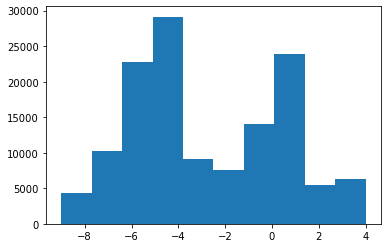

In [22]:
plt.hist(result["Cloud"] - result["전운량(10분위)"])

쌍봉 분포를 보인다. 

차이가 전혀 없는 경우(평균이 0인 정규분포)와 차이가 5~6정도 나는 경우(평균이 5인 정규분포)로 나뉘는 것으로 보인다.

In [23]:
scipy.stats.kstest((result["Cloud"] - result["전운량(10분위)"]).dropna(), "norm")

KstestResult(statistic=0.6031363661771878, pvalue=0.0)

아쉽게도, 잔차는 정규분포를 따르지 않는다.

In [24]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]

,지점,지점명,forecast,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위),date,hour,Forecast time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
25226,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 05:00:00,34.0,55.0,4.1,269.0,1.0
25227,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 08:00:00,34.0,55.0,4.1,269.0,1.0
25228,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 11:00:00,33.0,55.0,4.1,269.0,1.0
25229,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 14:00:00,33.0,55.0,4.1,269.0,1.0
25230,129,서산,2018-08-03 15:00:00,34.6,3.6,250.0,54.0,6.0,2018-08-03,2018-08-03 15,2018-08-01 17:00:00,33.0,55.0,2.4,294.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174529,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-30 02:00:00,6.0,75.0,2.9,180.0,3.0
174538,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 05:00:00,6.0,75.0,3.3,168.0,3.0
174539,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 08:00:00,6.0,75.0,3.3,168.0,3.0
174540,129,서산,2021-01-31 18:00:00,7.8,2.0,200.0,70.0,8.0,2021-01-31,2021-01-31 18,2021-01-31 11:00:00,6.0,75.0,3.3,168.0,3.0


<AxesSubplot:>

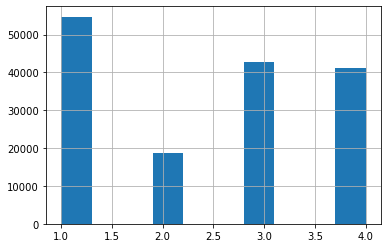

In [25]:
result["Cloud"].hist()

<AxesSubplot:>

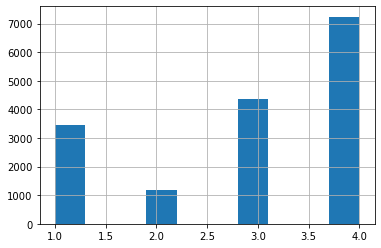

In [26]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["Cloud"].hist()

<AxesSubplot:>

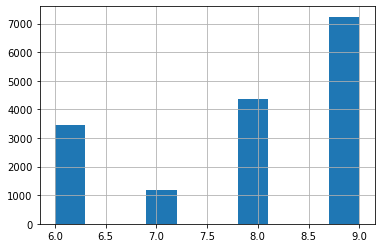

In [27]:
result[(result["Cloud"] - result["전운량(10분위)"]) == -5]["전운량(10분위)"].hist()

전운량의 예측은 1 ~ 4밖에 없다. 

예측 오차가 크게 나는 경우는 실제 전운량이 6 이상으로 나타나는 경우였다.

In [28]:
dangjin_fcst.describe()

,Temperature,Humidity,WindSpeed,WindDirection,Cloud
count,162208.000000,162208.000000,162208.000000,162208.000000,162208.000000
mean,12.624634,76.996147,3.639262,214.147761,2.439411
std,9.816256,17.435418,2.627592,108.020035,1.214753
min,-14.000000,5.000000,0.000000,0.000000,1.000000
25%,4.000000,65.000000,1.900000,115.000000,1.000000
50%,13.000000,80.000000,2.800000,237.000000,3.000000
75%,21.000000,90.000000,4.600000,313.000000,4.000000
max,36.000000,100.000000,32.299999,360.000000,4.000000


## 2) 변수 선별

### (1) 변수 선별용 데이터 전처리

#### - X, y 데이터 생성

In [29]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

In [30]:
energy["time"] = pd.to_datetime(
    DataFrame(list(energy["time"].str.split(" ")))[0] + 
    " " 
    + (temp[0].astype("int") - 1).astype("str") + ":" + temp[1] + ":" + temp[2])

In [31]:
energy_obs = pd.merge(energy, dangjin_obs, left_on = "time", right_on = "forecast", how = "left")

In [32]:
energy_obs = energy_obs.dropna().reset_index(drop = True)

energy_obs = energy_obs.drop(["date","hour", "지점", "지점명", "forecast"], axis = 1)

#### - 일출 일몰 정보 생성

In [33]:
def day_night(x):
    if x < 6 or x > 18:
        return 0
    else:
        return 1

In [34]:
energy_obs["day_night"] = energy_obs["time"].dt.hour.apply(lambda x : day_night(int(x)))

### (2) Boruta 알고리즘 활용

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state = 42)
forest.fit(energy_obs[["기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)", "day_night"]], 
           energy_obs["dangjin_warehouse"].to_numpy())

RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [490]:
from boruta import BorutaPy

feat_selector = BorutaPy(forest, 
                         n_estimators='auto',
                         verbose=2, 
                         random_state=42)

# find all relevant features
feat_selector.fit(energy_obs[["기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)", "day_night"]].to_numpy(), 
                  energy_obs["dangjin_warehouse"].to_numpy())

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(energy_obs[["기온(°C)", "풍속(m/s)", "풍향(16방위)", "습도(%)", "전운량(10분위)", "day_night"]].to_numpy())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	0


BorutaPy finish

선별된 변수는 없다. 모든 변수를 다 활용할 것이다.

# 3. 데이터 전처리

## 1) 결측값 대체

### (1) fcst 보간

#### - spline 보간

In [35]:
energy['time'] = energy['time'].astype('str')

In [36]:
temp = DataFrame(list(DataFrame(list(energy["time"].str.split(" ")))[1].str.split(":")))

energy["time"] = pd.to_datetime(
    DataFrame(list(energy["time"].str.split(" ")))[0] + 
    " " 
    + (temp[0].astype("int") - 1).astype("str") + ":" + temp[1] + ":" + temp[2])

energy = energy.dropna().reset_index(drop = True)

In [37]:
def time_interpolate(x, data):
    
    temp = data[data["time"].dt.date == x].drop_duplicates("time", keep = "last")
    
    min_time = np.min(temp["time"])
    
    max_time = min_time + pd.Timedelta(hours = 23)
    
    time_index = pd.date_range(min_time, max_time, freq = "H")
    
    temp = pd.merge(pd.Series(pd.date_range(min_time, max_time, freq = "H"),name = "time"),
         temp,
         how = "left")
    
    return temp

In [38]:
dangjin_fcst = dangjin_fcst.dropna(axis = 0, subset = ["Temperature","Humidity", "WindSpeed", "WindDirection"]).reset_index(drop = True)

dangjin_fcst["Forecast time"] = pd.to_datetime(dangjin_fcst["Forecast time"])

dangjin_fcst = dangjin_fcst.rename(columns = {"forecast":"time"})

result = pd.Series(dangjin_fcst["time"].dt.date.unique()).apply(lambda x : time_interpolate(x, dangjin_fcst))

dangjin_fcst = pd.concat(list(result))

del dangjin_fcst["Forecast time"]

dangjin_fcst = dangjin_fcst.drop_duplicates("time").reset_index(drop = True)

In [39]:
dangjin_fcst.iloc[:,1:] = dangjin_fcst.iloc[:,1:].apply(lambda x : x.interpolate(method = "spline", order = 2))

In [40]:
ulsan_fcst = ulsan_fcst.dropna(axis = 0, subset = ["Temperature","Humidity", "WindSpeed", "WindDirection"]).reset_index(drop = True)

ulsan_fcst["Forecast time"] = pd.to_datetime(ulsan_fcst["Forecast time"])

ulsan_fcst = ulsan_fcst.rename(columns = {"forecast":"time"})

result = pd.Series(ulsan_fcst["time"].dt.date.unique()).apply(lambda x : time_interpolate(x, ulsan_fcst))

ulsan_fcst = pd.concat(list(result))

del ulsan_fcst["Forecast time"]

ulsan_fcst = ulsan_fcst.drop_duplicates("time").reset_index(drop = True)

In [41]:
ulsan_fcst.iloc[:,1:] = ulsan_fcst.iloc[:,1:].apply(lambda x : x.interpolate(method = "spline", order = 2))

## 2) 파생 변수 생성

### (1) day_night 변수 추가

In [42]:
def day_night(x):
    if x < 5 or x > 19:
        return 0
    else:
        return 1

In [43]:
dangjin_fcst["day_night"] = dangjin_fcst["time"].dt.hour.apply(lambda x : day_night(int(x)))

In [44]:
ulsan_fcst["day_night"] = ulsan_fcst["time"].dt.hour.apply(lambda x : day_night(int(x)))

### (2) 월 변수 추가

#### - dangjin

In [45]:
temp = pd.DataFrame(dangjin_fcst["time"]).copy()

In [46]:
temp["month"] = dangjin_fcst["time"].dt.month
temp["year"] = dangjin_fcst["time"].dt.year
temp["year"] = temp["year"].apply(lambda x : int(np.where(temp["year"].unique() == x)[0]))
temp["day"] = dangjin_fcst["time"].dt.day

temp["hour"] = dangjin_fcst["time"].dt.hour

In [47]:
dangjin_fcst = pd.merge(dangjin_fcst, temp, how = "left")

In [48]:
energy_fcst_dangjin = pd.merge(energy, dangjin_fcst).dropna()

#### - ulsan

In [49]:
temp = pd.DataFrame(ulsan_fcst["time"]).copy()

In [50]:
temp["month"] = ulsan_fcst["time"].dt.month
temp["year"] = ulsan_fcst["time"].dt.year
temp["year"] = temp["year"].apply(lambda x : int(np.where(temp["year"].unique() == x)[0]))
temp["day"] = ulsan_fcst["time"].dt.day

temp["hour"] = ulsan_fcst["time"].dt.hour

In [51]:
ulsan_fcst = pd.merge(ulsan_fcst, temp)

In [52]:
energy_fcst_ulsan = pd.merge(energy, ulsan_fcst, how = "left").dropna()

# 4. 모델링

## 1) train_test 분할

### (1) 당진 분할

In [53]:
temp = DataFrame(energy_fcst_dangjin["time"].dt.date)

In [54]:
def gen():
    n = 0
    while True:
        n += 1
        yield n
        
num = gen()

In [55]:
temp = temp.groupby("time").apply(lambda x : next(num))

temp = temp.reset_index(name = "num")
temp.columns = ["date","num"]

energy_fcst_dangjin["date"] = energy_fcst_dangjin["time"].dt.date

energy_fcst_dangjin = pd.merge(energy_fcst_dangjin, temp)

k = energy_fcst_dangjin.groupby("num").apply(lambda x : len(x) / 24)

k = k.reset_index(name = "ratio")

k_full = DataFrame(list(set(k["num"]).difference(set(k.loc[k["ratio"] < 1, "num"]))),
         columns = ["num"])

energy_fcst_dangjin = pd.merge(k_full, 
         energy_fcst_dangjin,
         how = "left")

#train_num = np.random.choice(energy_fcst_dangjin["num"].unique(),
#              size = int(len(energy_fcst_dangjin["num"].unique()) * 0.75),
#                replace = False)

train_num = [i for i in range(0, len(energy_fcst_dangjin["num"].unique()) - 30)]

test_num = [i for i in range(len(energy_fcst_dangjin["num"].unique()) - 30, 
                            len(energy_fcst_dangjin["num"].unique()))]

train = pd.merge(DataFrame(train_num, columns = ["num"]), energy_fcst_dangjin)

test = pd.merge(DataFrame(test_num, columns = ["num"]), energy_fcst_dangjin)

X_train_dangjin = train[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",
                         "num"]]

X_train_dangjin = X_train_dangjin.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",]].to_numpy())

X_test_dangjin = test[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",
                       "num"]]

X_test_dangjin = X_test_dangjin.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "month",
                         "year",
                         "day",
                         "hour",]].to_numpy())

X_train_dangjin = np.stack(X_train_dangjin)
X_test_dangjin = np.stack(X_test_dangjin)

In [56]:
y_train_dangjin = train[["num","dangjin"]]
y_test_dangjin = test[["num","dangjin"]]

y_train_dangjin = np.stack(y_train_dangjin.groupby("num").apply(lambda x : np.array(x["dangjin"])))
y_test_dangjin = np.stack(y_test_dangjin.groupby("num").apply(lambda x : np.array(x["dangjin"])))

In [57]:
y_train_dangjin_ware = train[["num","dangjin_warehouse"]]
y_test_dangjin_ware = test[["num","dangjin_warehouse"]]

y_train_dangjin_ware = np.stack(y_train_dangjin_ware.groupby("num").apply(lambda x : np.array(x["dangjin_warehouse"])))
y_test_dangjin_ware = np.stack(y_test_dangjin_ware.groupby("num").apply(lambda x : np.array(x["dangjin_warehouse"])))

In [58]:
y_train_dangjin_float = train[["num","dangjin_floating"]]
y_test_dangjin_float = test[["num","dangjin_floating"]]

y_train_dangjin_float = np.stack(y_train_dangjin_float.groupby("num").apply(lambda x : np.array(x["dangjin_floating"])))
y_test_dangjin_float = np.stack(y_test_dangjin_float.groupby("num").apply(lambda x : np.array(x["dangjin_floating"])))

### (2) 울산 분할

In [59]:
temp = DataFrame(energy_fcst_ulsan["time"].dt.date)

In [60]:
temp = temp.groupby("time").apply(lambda x : next(num))

temp = temp.reset_index(name = "num")
temp.columns = ["date","num"]

energy_fcst_ulsan["date"] = energy_fcst_ulsan["time"].dt.date

energy_fcst_ulsan = pd.merge(energy_fcst_ulsan, temp)

k = energy_fcst_ulsan.groupby("num").apply(lambda x : len(x) / 24)

In [61]:
k = k.reset_index(name = "ratio")

k_full = DataFrame(list(set(k["num"]).difference(set(k.loc[k["ratio"] < 1, "num"]))),
         columns = ["num"])

energy_fcst_ulsan = pd.merge(k_full, 
         energy_fcst_ulsan,
         how = "left")

#train_num = np.random.choice(energy_fcst_dangjin["num"].unique(),
#              size = int(len(energy_fcst_dangjin["num"].unique()) * 0.75),
#                replace = False)

train_num = [i for i in range(np.min(energy_fcst_ulsan["num"].unique()), 
                              np.max(energy_fcst_ulsan["num"].unique()) - 30)]

test_num = [i for i in range(np.max(energy_fcst_ulsan["num"].unique()) - 30, 
                            np.max(energy_fcst_ulsan["num"].unique()) + 1)]

train = pd.merge(DataFrame(train_num, columns = ["num"]), energy_fcst_ulsan)

test = pd.merge(DataFrame(test_num, columns = ["num"]), energy_fcst_ulsan)

X_train_ulsan = train[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",
                         "num"]]

X_train_ulsan = X_train_ulsan.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",]].to_numpy())

X_test_ulsan = test[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",
                       "num"]]

X_test_ulsan = X_test_ulsan.groupby('num').apply(lambda x : x[["Temperature", 
                         "Humidity", 
                         "WindSpeed", 
                         "Cloud",
                         "year",
                         "month",
                         "day",
                         "hour",]].to_numpy())

X_train_ulsan = np.stack(X_train_ulsan)
X_test_ulsan = np.stack(X_test_ulsan)

In [62]:
y_train_ulsan = train[["num","ulsan"]]
y_test_ulsan = test[["num","ulsan"]]

y_train_ulsan = np.stack(y_train_ulsan.groupby("num").apply(lambda x : np.array(x["ulsan"])))
y_test_ulsan = np.stack(y_test_ulsan.groupby("num").apply(lambda x : np.array(x["ulsan"])))

## 1) LightGBM

### (1) Parameter Tune

#### - dangjin

In [108]:
X_train_dangjin_lgb, X_valid_dangjin_lgb, y_train_dangjin_lgb, y_valid_dangjin_lgb = train_test_split(X_train_dangjin, y_train_dangjin, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [109]:
X_test_dangjin_lgb = np.reshape(X_test_dangjin, [-1,np.shape(X_test_dangjin)[-1]])
y_test_dangjin_lgb = np.reshape(y_test_dangjin, [-1])

In [110]:
X_train_dangjin_lgb = np.reshape(X_train_dangjin_lgb, [-1,np.shape(X_train_dangjin_lgb)[-1]])
X_valid_dangjin_lgb = np.reshape(X_valid_dangjin_lgb, [-1,np.shape(X_valid_dangjin_lgb)[-1]])

In [111]:
y_train_dangjin_lgb = np.reshape(y_train_dangjin_lgb, [-1])
y_valid_dangjin_lgb = np.reshape(y_valid_dangjin_lgb, [-1])

In [112]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangjin_lgb)
test_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
val_dataset = lgb.Dataset(X_valid_dangjin_lgb, y_valid_dangjin_lgb)

In [113]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [114]:
from sklearn.metrics import r2_score, mean_squared_error

def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

    y_pred = model.predict(X_valid_dangjin_lgb)

    mae = np.mean(nmae_10(y_valid_dangjin_lgb, y_pred))

    return 1/mae

In [115]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1),
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=1 )

bo.maximize(init_points=2, n_iter=100, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  1        |  0.09806  |  0.4171   |  0.7204   |  0.000114 |  0.06054  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [I

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  11       |  0.09973  |  0.02319  |  0.7994   |  0.9642   |  0.1418   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  12       |  0.09951  |  0.09389  |  1.0      |  0.7747   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00014

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  25       |  0.09941  |  0.7165   |  1.0      |  0.8179   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  26       |  0.03595  |  1.0      |  1.0      |  0.8678   |  0.0001   |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  33       |  0.09767  |  1.0      |  0.6442   |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  34       |  0.09561  |  1.0      |  0.3194   |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  49       |  0.09852  |  0.5143   |  1.0      |  0.4293   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  50       |  0.09876  |  1.0      |  0.5622   |  0.7367   |  0.2      |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  59       |  0.03584  |  1.0      |  0.4202   |  0.8745   |  0.0001   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  60       |  0.09849  |  0.8467   |  0.5415   |  0.5404   |  0.2      |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  69       |  0.0986   |  0.3068   |  0.7956   |  0.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  79       |  0.1001   |  0.5414   |  0.8931   |  0.8572   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  80       |  0.09883  |  0.6042   |  0.6901   |  0.6522   |  0.08308  |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  95       |  0.09767  |  0.7944   |  0.6702   |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
|  96       |  0.09557  |  0.805    |  0.8515   |  0.4973   |  0.03854  |
[LightGBM] [Warning] Auto-choosi

In [116]:
def nmae_10_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [117]:
params = {"learning_rate": 0.11703047303328216,
            "feature_fraction" : 0.917548055585948,
            "bagging_fraction" : 0.4542746828242898, 
           "lambda_l2" :  0.2836245541577052,
          "objective" : 'regression'
            }

In [118]:
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 9187.11	valid_0's score: 11.2619
[1000]	valid_0's l2: 9545.01	valid_0's score: 11.5843
Early stopping, best iteration is:
[29]	valid_0's l2: 8419.05	valid_0's score: 10.4238


In [119]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [120]:
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l1: 44.8488	valid_0's score: 10.5566
[1000]	valid_0's l1: 46.0278	valid_0's score: 10.5881
Early stopping, best iteration is:
[408]	valid_0's l1: 45.9944	valid_0's score: 10.466


#### - dangjin_ware

In [121]:
X_train_dangjin_lgb, X_valid_dangjin_lgb, y_train_dangjin_lgb, y_valid_dangjin_lgb = train_test_split(X_train_dangjin, 
                                                                                                      y_train_dangjin_ware, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [122]:
X_train_dangjin_lgb = np.reshape(X_train_dangjin_lgb, [-1,np.shape(X_train_dangjin_lgb)[-1]])
X_valid_dangjin_lgb = np.reshape(X_valid_dangjin_lgb, [-1,np.shape(X_valid_dangjin_lgb)[-1]])

In [123]:
y_train_dangjin_lgb = np.reshape(y_train_dangjin_lgb, [-1])
y_valid_dangjin_lgb = np.reshape(y_valid_dangjin_lgb, [-1])

In [124]:
X_test_dangjin_lgb = np.reshape(X_test_dangjin, [-1,np.shape(X_test_dangjin)[-1]])
y_test_dangjin_lgb = np.reshape(y_test_dangjin_ware, [-1])

In [125]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangjin_lgb)
test_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
val_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)

In [126]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [127]:
from sklearn.metrics import r2_score, mean_squared_error


# 탐색 대상 함수 (XGBRegressor)
def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
  # 모델 정의
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

  # 예측값 출력
    y_pred = model.predict(X_valid_dangjin_lgb)

  # 각종 metric 계산
    mae = np.mean(nmae_10(y_valid_dangjin_lgb, y_pred))

  # 오차 최적화로 사용할 metric 반환
    return 1/mae

In [128]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1),
            }

capacity = 700
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=42 )

bo.maximize(init_points=2, n_iter=100, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  1        |  0.1058   |  0.3746   |  0.9507   |  0.732    |  0.1198   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
[LightGBM] [Warning] No 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  11       |  0.1046   |  0.1735   |  0.6761   |  0.9404   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  12       |  0.03764  |  0.0001   |  0.7821   |  0.8588   |  0.0001   |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  22       |  0.1038   |  0.5614   |  0.7788   |  0.7081   |  0.1854   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  23       |  0.1044   |  0.5538   |  0.9907   |  0.00868  |  0.1915   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000064 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  32       |  0.1021   |  0.9879   |  0.6858   |  0.4316   |  0.1903   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  33       |  0.1032   |  0.2939   |  0.6838   |  0.643    |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  39       |  0.1029   |  0.2284   |  0.943    |  0.3377   |  0.1803   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  40       |  0.1045   |  0.533    |  0.8065   |  0.9498   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  56       |  0.1036   |  1.0      |  0.784    |  0.7218   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  57       |  0.1025   |  0.4944   |  1.0      |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  69       |  0.05459  |  0.3487   |  0.07109  |  0.9799   |  0.1125   |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  85       |  0.08965  |  0.4647   |  0.6815   |  0.04797  |  0.02603  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  86       |  0.09273  |  1.0      |  0.5464   |  0.4248   |  0.03433  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 

|  100      |  0.1054   |  0.4756   |  0.8511   |  0.7944   |  0.1463   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  101      |  0.1037   |  0.9139   |  0.5939   |  0.7031   |  0.1689   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
|  102      |  0.1018   |  0.3593 

In [129]:
params = {"learning_rate": 0.2,
            "feature_fraction" : 1,
            "bagging_fraction" : 1, 
           "lambda_l2" :  0.4895603572656096,
          "objective" : 'regression'
            }

In [130]:
capacity = 700
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 5836.37	valid_0's score: 12.9342
[1000]	valid_0's l2: 5963.06	valid_0's score: 12.898
Early stopping, best iteration is:
[11]	valid_0's l2: 3828.07	valid_0's score: 10.5533


In [131]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [132]:
capacity = 700
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l1: 30.7167	valid_0's score: 10.3841
[1000]	valid_0's l1: 36.7864	valid_0's score: 11.367
Early stopping, best iteration is:
[391]	valid_0's l1: 31.4522	valid_0's score: 10.3145


#### - dangjin_float

In [133]:
X_train_dangjin_lgb, X_valid_dangjin_lgb, y_train_dangjin_lgb, y_valid_dangjin_lgb = train_test_split(X_train_dangjin, 
                                                                                                      y_train_dangjin_float, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [134]:
X_train_dangjin_lgb = np.reshape(X_train_dangjin_lgb, [-1,np.shape(X_train_dangjin_lgb)[-1]])
X_valid_dangjin_lgb = np.reshape(X_valid_dangjin_lgb, [-1,np.shape(X_valid_dangjin_lgb)[-1]])

In [135]:
y_train_dangjin_lgb = np.reshape(y_train_dangjin_lgb, [-1])
y_valid_dangjin_lgb = np.reshape(y_valid_dangjin_lgb, [-1])

In [136]:
X_test_dangjin_lgb = np.reshape(X_test_dangjin, [-1,np.shape(X_test_dangjin)[-1]])
y_test_dangjin_lgb = np.reshape(y_test_dangjin_float, [-1])

In [137]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangjin_lgb)
test_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
val_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)

In [138]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [139]:
from sklearn.metrics import r2_score, mean_squared_error


# 탐색 대상 함수 (XGBRegressor)
def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
  # 모델 정의
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

  # 예측값 출력
    y_pred = model.predict(X_valid_dangjin_lgb)

  # 각종 metric 계산
    mae = np.mean(nmae_10(y_valid_dangjin_lgb, y_pred))

  # 오차 최적화로 사용할 metric 반환
    return 1/mae

In [140]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1),
            }

capacity = 1000
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=42 )

bo.maximize(init_points=2, n_iter=100, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  1        |  0.1214   |  0.3746   |  0.9507   |  0.732    |  0.1198   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [I

And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  12       |  0.1057   |  0.006203 |  0.4735   |  0.9841   |  0.08028  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  13       |  0.1177   |  0.6887   |  0.8659   |  0.3238   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  21       |  0.1167   |  1.0      |  0.5109   |  0.08687  |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  22       |  0.1131   |  1.0      |  0.2903   |  0.4716   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00005

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  47       |  0.1147   |  0.6424   |  0.7261   |  0.5151   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  48       |  0.1159   |  0.4556   |  0.8834   |  0.7758   |  0.2      |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  63       |  0.1165   |  0.8018   |  0.8591   |  0.5172   |  0.2      |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  64       |  0.1183   |  0.8511   |  0.7224   |  0.2822   |  0.1079   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00006

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  70       |  0.1132   |  0.0001   |  0.7077   |  0.998    |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  71       |  0.1177   |  0.2709   |  0.7795   |  0.7996   |  0.1605   |
[LightGBM] [Warning] Auto-choosi

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  86       |  0.1036   |  0.6692   |  0.6599   |  0.4219   |  0.02823  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
|  87       |  0.118    |  0.583    |  0.8873   |  0.4744   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00012

In [141]:
params = {"learning_rate": 0.11977183099098763,
            "feature_fraction" : 0.9507192349792751,
            "bagging_fraction" : 0.37460266483547777, 
           "lambda_l2" :  0.7319939418114051,
          "objective" : 'regression'
            }

In [142]:
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 6379.21	valid_0's score: 9.28699
[1000]	valid_0's l2: 6618.53	valid_0's score: 9.45409
Early stopping, best iteration is:
[39]	valid_0's l2: 5322.11	valid_0's score: 8.2527


In [143]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [144]:

capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l1: 37.6663	valid_0's score: 8.10502
[1000]	valid_0's l1: 36.7503	valid_0's score: 8.19653
Early stopping, best iteration is:
[340]	valid_0's l1: 40.6576	valid_0's score: 8.04963


#### -ulsan

In [145]:
X_train_ulsan_lgb, X_valid_ulsan_lgb, y_train_ulsan_lgb, y_valid_ulsan_lgb = train_test_split(X_train_ulsan, 
                                                                                                      y_train_ulsan, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [146]:
X_train_ulsan_lgb = np.reshape(X_train_ulsan_lgb, [-1,np.shape(X_train_ulsan_lgb)[-1]])
X_valid_ulsan_lgb = np.reshape(X_valid_ulsan_lgb, [-1,np.shape(X_valid_ulsan_lgb)[-1]])

In [147]:
y_train_ulsan_lgb = np.reshape(y_train_ulsan_lgb, [-1])
y_valid_ulsan_lgb = np.reshape(y_valid_ulsan_lgb, [-1])

In [148]:
X_test_ulsan_lgb = np.reshape(X_test_ulsan, [-1,np.shape(X_test_ulsan)[-1]])
y_test_ulsan_lgb = np.reshape(y_test_ulsan, [-1])

In [149]:
train_dataset = lgb.Dataset(X_train_ulsan_lgb, y_train_ulsan_lgb)
test_dataset = lgb.Dataset(X_test_ulsan_lgb, y_test_ulsan_lgb)
val_dataset = lgb.Dataset(X_valid_ulsan_lgb, y_valid_ulsan_lgb)

In [150]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [151]:
from sklearn.metrics import r2_score, mean_squared_error


# 탐색 대상 함수 (XGBRegressor)
def LGB_cv(learning_rate, 
           feature_fraction, 
           bagging_fraction,
           lambda_l2,
           silent=True, 
           nthread=-1):

    params = {"learning_rate": learning_rate,
                "feature_fraction" : feature_fraction,
                "bagging_fraction" : bagging_fraction, 
               "lambda_l2" : lambda_l2,
               "objective" :  "regression",
              "nthread" : nthread
                }
    
  # 모델 정의
    model = lgb.train(params,
                      train_dataset,
                      feval = nmae_10
                     )

  # 예측값 출력
    y_pred = model.predict(X_valid_ulsan_lgb)

  # 각종 metric 계산
    mae = np.mean(nmae_10(y_valid_ulsan_lgb, y_pred))

  # 오차 최적화로 사용할 metric 반환
    return 1/mae

In [152]:
import scipy.optimize as optimize
from bayes_opt import BayesianOptimization

params = {"learning_rate": (0.0001, 0.2),
            "feature_fraction" : (0.0001, 1),
            "bagging_fraction" : (0.0001, 1), 
           "lambda_l2" : (0 , 1),
            }

capacity = 500
train_max = 1
train_min = 0

bo=BayesianOptimization(f=LGB_cv, 
                        pbounds=params, 
                        verbose=2, 
                        random_state=1 )

bo.maximize(init_points=2, n_iter=100, acq='ei', xi=0.01)

print(bo.max)

|   iter    |  target   | baggin... | featur... | lambda_l2 | learni... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  1        |  0.12     |  0.4171   |  0.7204   |  0.000114 |  0.06054  |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
[LightGBM] [Warning] No 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  11       |  0.1213   |  0.5029   |  0.5716   |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  12       |  0.04056  |  0.243    |  0.7625   |  0.7078   |  0.0001   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  23       |  0.1243   |  1.0      |  1.0      |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  24       |  0.1241   |  0.77     |  1.0      |  0.7728   |  0.2      |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  32       |  0.1036   |  0.6551   |  0.2178   |  0.7027   |  0.1814   |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  33       |  0.1232   |  0.5897   |  1.0      |  0.602

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  52       |  0.1237   |  0.4191   |  0.967    |  0.4676   |  0.197    |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  53       |  0.1229   |  0.4122   |  0.952    |  0.471    |  0.184    |
[LightGBM] [Warning] Auto-choosing

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  66       |  0.1236   |  0.0001   |  1.0      |  0.423    |  0.2      |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  67       |  0.1213   |  0.4921   |  0.6873   |  0.4875   |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 

|  75       |  0.1229   |  0.5273   |  0.8081   |  0.79     |  0.1287   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  76       |  0.1227   |  0.4181   |  0.8334   |  1.0      |  0.2      |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  77       |  0.117    |  0.9143 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  92       |  0.1193   |  0.5923   |  0.6222   |  0.845    |  0.0708   |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
|  93       |  0.1244   |  0.8554   |  0.8524   |  0.8104   |  0.2      |
[LightGBM] [Warning] Auto-choosing

In [153]:
params = {"learning_rate": 0.13790082625336098,
            "feature_fraction" : 0.9124991619004987,
            "bagging_fraction" : 0.9307091108023549, 
           "lambda_l2" :  0.7549427348064354,
          "objective" : 'regression'
            }

In [154]:
capacity = 500
dangjin_model = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 808.105	valid_0's score: 6.87715
[1000]	valid_0's l2: 841.875	valid_0's score: 7.07593
Early stopping, best iteration is:
[83]	valid_0's l2: 712.239	valid_0's score: 6.67974


In [155]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [156]:
capacity = 500
dangjin_model = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l1: 12.9847	valid_0's score: 6.52038
[1000]	valid_0's l1: 12.2772	valid_0's score: 6.31288
[1500]	valid_0's l1: 12.6493	valid_0's score: 6.37416
Early stopping, best iteration is:
[943]	valid_0's l1: 12.2219	valid_0's score: 6.33024


### (2) 모델 학습

In [157]:
def nmae_10_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

#### -dangjin

In [158]:
X_train_dangjin_lgb, X_valid_dangjin_lgb, y_train_dangjin_lgb, y_valid_dangjin_lgb = train_test_split(X_train_dangjin, y_train_dangjin, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [159]:
X_test_dangjin_lgb = np.reshape(X_test_dangjin, [-1,np.shape(X_test_dangjin)[-1]])
y_test_dangjin_lgb = np.reshape(y_test_dangjin, [-1])

In [160]:
X_train_dangjin_lgb = np.reshape(X_train_dangjin_lgb, [-1,np.shape(X_train_dangjin_lgb)[-1]])
X_valid_dangjin_lgb = np.reshape(X_valid_dangjin_lgb, [-1,np.shape(X_valid_dangjin_lgb)[-1]])

In [161]:
y_train_dangjin_lgb = np.reshape(y_train_dangjin_lgb, [-1])
y_valid_dangjin_lgb = np.reshape(y_valid_dangjin_lgb, [-1])

In [162]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangjin_lgb)
test_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
val_dataset = lgb.Dataset(X_valid_dangjin_lgb, y_valid_dangjin_lgb)

In [165]:
params = {"learning_rate": 0.11703047303328216,
            "feature_fraction" : 0.917548055585948,
            "bagging_fraction" : 0.4542746828242898, 
           "lambda_l2" :  0.2836245541577052,
          "objective" : 'regression'
            }

In [166]:
capacity = 1000
Models_dangjin = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 139.977576
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 9187.11	valid_0's score: 11.2619
[1000]	valid_0's l2: 9545.01	valid_0's score: 11.5843
Early stopping, best iteration is:
[29]	valid_0's l2: 8419.05	valid_0's score: 10.4238


#### -dangjin_ware

In [167]:
X_train_dangjin_lgb, X_valid_dangjin_lgb, y_train_dangjin_lgb, y_valid_dangjin_lgb = train_test_split(X_train_dangjin, 
                                                                                                      y_train_dangjin_ware, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [168]:
X_train_dangjin_lgb = np.reshape(X_train_dangjin_lgb, [-1,np.shape(X_train_dangjin_lgb)[-1]])
X_valid_dangjin_lgb = np.reshape(X_valid_dangjin_lgb, [-1,np.shape(X_valid_dangjin_lgb)[-1]])

In [169]:
y_train_dangjin_lgb = np.reshape(y_train_dangjin_lgb, [-1])
y_valid_dangjin_lgb = np.reshape(y_valid_dangjin_lgb, [-1])

In [170]:
X_test_dangjin_lgb = np.reshape(X_test_dangjin, [-1,np.shape(X_test_dangjin)[-1]])
y_test_dangjin_lgb = np.reshape(y_test_dangjin_ware, [-1])

In [171]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangjin_lgb)
test_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
val_dataset = lgb.Dataset(X_valid_dangjin_lgb, y_valid_dangjin_lgb)

In [172]:
params = {"learning_rate": 0.2,
            "feature_fraction" : 1,
            "bagging_fraction" : 1, 
           "lambda_l2" :  0.4895603572656096,
          "objective" : 'regression'
            }

In [173]:
capacity = 700
Models_dangjin_warehouse = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 92.546364
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 5836.37	valid_0's score: 12.9342
[1000]	valid_0's l2: 5963.06	valid_0's score: 12.898
Early stopping, best iteration is:
[11]	valid_0's l2: 3828.07	valid_0's score: 10.5533


#### - dangjin_float

In [174]:
X_train_dangjin_lgb, X_valid_dangjin_lgb, y_train_dangjin_lgb, y_valid_dangjin_lgb = train_test_split(X_train_dangjin, 
                                                                                                      y_train_dangjin_float, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [175]:
X_train_dangjin_lgb = np.reshape(X_train_dangjin_lgb, [-1,np.shape(X_train_dangjin_lgb)[-1]])
X_valid_dangjin_lgb = np.reshape(X_valid_dangjin_lgb, [-1,np.shape(X_valid_dangjin_lgb)[-1]])

In [176]:
y_train_dangjin_lgb = np.reshape(y_train_dangjin_lgb, [-1])
y_valid_dangjin_lgb = np.reshape(y_valid_dangjin_lgb, [-1])

In [177]:
X_test_dangjin_lgb = np.reshape(X_test_dangjin, [-1,np.shape(X_test_dangjin)[-1]])
y_test_dangjin_lgb = np.reshape(y_test_dangjin_float, [-1])

In [178]:
train_dataset = lgb.Dataset(X_train_dangjin_lgb, y_train_dangjin_lgb)
test_dataset = lgb.Dataset(X_test_dangjin_lgb, y_test_dangjin_lgb)
val_dataset = lgb.Dataset(X_valid_dangjin_lgb, y_valid_dangjin_lgb)

In [179]:
params = {"learning_rate": 0.11977183099098763,
            "feature_fraction" : 0.9507192349792751,
            "bagging_fraction" : 0.37460266483547777, 
           "lambda_l2" :  0.7319939418114051,
          "objective" : 'regression'
            }

In [180]:
capacity = 1000
Models_dangjin_floating = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19800, number of used features: 9
[LightGBM] [Info] Start training from score 122.399495
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 6379.21	valid_0's score: 9.28699
[1000]	valid_0's l2: 6618.53	valid_0's score: 9.45409
Early stopping, best iteration is:
[39]	valid_0's l2: 5322.11	valid_0's score: 8.2527


#### - ulsan

In [181]:
X_train_ulsan_lgb, X_valid_ulsan_lgb, y_train_ulsan_lgb, y_valid_ulsan_lgb = train_test_split(X_train_ulsan, 
                                                                                                      y_train_ulsan, 
                                                                                                      test_size = 0.2,
                                                                                                     random_state = 42)

In [182]:
X_train_ulsan_lgb = np.reshape(X_train_ulsan_lgb, [-1,np.shape(X_train_ulsan_lgb)[-1]])
X_valid_ulsan_lgb = np.reshape(X_valid_ulsan_lgb, [-1,np.shape(X_valid_ulsan_lgb)[-1]])

In [183]:
y_train_ulsan_lgb = np.reshape(y_train_ulsan_lgb, [-1])
y_valid_ulsan_lgb = np.reshape(y_valid_ulsan_lgb, [-1])

In [184]:
X_test_ulsan_lgb = np.reshape(X_test_ulsan, [-1,np.shape(X_test_ulsan)[-1]])
y_test_ulsan_lgb = np.reshape(y_test_ulsan, [-1])

In [185]:
train_dataset = lgb.Dataset(X_train_ulsan_lgb, y_train_ulsan_lgb)
test_dataset = lgb.Dataset(X_test_ulsan_lgb, y_test_ulsan_lgb)
val_dataset = lgb.Dataset(X_valid_ulsan_lgb, y_valid_ulsan_lgb)

In [186]:
params = {"learning_rate": 0.13790082625336098,
            "feature_fraction" : 0.9124991619004987,
            "bagging_fraction" : 0.9307091108023549, 
           "lambda_l2" :  0.7549427348064354,
          "objective" : 'regression'
            }

In [187]:
capacity = 500
Models_ulsan = lgb.train(params, train_dataset, 10000, test_dataset, feval=nmae_10_lgb, verbose_eval=500, early_stopping_rounds=1000)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1094
[LightGBM] [Info] Number of data points in the train set: 19824, number of used features: 9
[LightGBM] [Info] Start training from score 64.663186
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's l2: 808.105	valid_0's score: 6.87715
[1000]	valid_0's l2: 841.875	valid_0's score: 7.07593
Early stopping, best iteration is:
[83]	valid_0's l2: 712.239	valid_0's score: 6.67974


### 2) LSTM_AUTOENCODER

### (1) min_max_scale

In [63]:
train_min_dangjin = np.min(X_train_dangjin)
train_max_dangjin = np.max(X_train_dangjin)

X_train_dangjin_scaled = (X_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

X_test_dangjin_scaled = (X_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

#X_train_dangjin_scaled[:,:,4] = X_train_dangjin[:,:,4]

#X_test_dangjin_scaled[:,:,4] = X_test_dangjin[:,:,4]

In [64]:
y_train_dangjin_scaled = (y_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_scaled = (y_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [65]:
y_train_dangjin_ware_scaled = (y_train_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_ware_scaled = (y_test_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [66]:
y_train_dangjin_float_scaled = (y_train_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_float_scaled = (y_test_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

#### - 울산

In [67]:
train_min_ulsan = np.min(X_train_ulsan)
train_max_ulsan = np.max(X_train_ulsan)

X_train_ulsan_scaled = (X_train_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

X_test_ulsan_scaled = (X_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

#X_train_ulsan_scaled[:,:,4] = X_train_ulsan[:,:,4]

#X_test_ulsan_scaled[:,:,4] = X_test_ulsan[:,:,4]

In [68]:
y_train_ulsan_scaled = (y_train_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

y_test_ulsan_scaled = (y_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

In [69]:
class TrainModel(tf.keras.Model):
    def __init__(self,
                 kernel_size, 
                 lstm_dim):
        
        super(TrainModel, self).__init__()
        
        self.kernel_size = kernel_size
        self.lstm_dim = lstm_dim
     
    def build(self, input_shape):
    
        
        self.lstm = tf.keras.layers.LSTM(self.lstm_dim,
                                        return_sequences = True)
        
        self.lstm_2 = tf.keras.layers.LSTM(int(self.lstm_dim / 2),
                                          return_sequences = True)
        
        self.lstm_3 = tf.keras.layers.LSTM(int(self.lstm_dim / 3))
        
        self.lstm_4 = tf.keras.layers.LSTM(int(self.lstm_dim / 2),
                                          return_sequences = True)
        
        self.lstm_5 = tf.keras.layers.LSTM(self.lstm_dim,
                                          return_sequences = True)
        
        self.repeat_vec = tf.keras.layers.RepeatVector(input_shape[1])
        
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        output_layer = tf.keras.layers.Dense(1, activation = "relu")
        
        self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor):
        
        lstm_enc = self.lstm(input_tensor)
        lstm_enc = self.lstm_2(lstm_enc)
        lstm_enc = self.lstm_3(lstm_enc)
        lstm_enc = self.dropout(lstm_enc)
        
        lstm_dec = self.repeat_vec(lstm_enc)
        
        lstm_dec = self.lstm_4(lstm_dec)
        lstm_dec = self.lstm_5(lstm_dec)
        lstm_dec = self.dropout(lstm_dec)
        
        output = self.outputs(lstm_dec)
        
        return output

In [63]:
Models_dangjin_warehouse = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_ulsan = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_dangjin = TrainModel(
                     kernel_size = 200, 
                      lstm_dim = 256)

Models_dangjin_floating = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

In [64]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [65]:
@tf.function()
def train_step_dangjin(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_dangjin(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin.trainable_variables)
    optimizer_tf.apply_gradients(zip(gradients, Models_dangjin.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [108]:
@tf.function()
def train_step_dangjin_ware(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_dangjin_warehouse(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin_warehouse.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin_warehouse.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [109]:
@tf.function()
def train_step_dangjin_float(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_dangjin_floating(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin_floating.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin_floating.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [110]:
@tf.function()
def train_step_ulsan(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_ulsan(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_ulsan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_ulsan.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [111]:
def val_accuracy(inp, tar, Models):
    output = Models(inp)
    
    test_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [216]:
EPOCHS = 2000
batch_size = 50

In [327]:
class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = layer.RNN(hidden_size)
        #self.l2 = layer.LSTM(int(hidden_size / 2))
        #self.l3 = layer.LSTM(hidden_size)
        self.l4 = layer.Linear(out_size, initializer_func='he_uniform')
        
    def forward(self, x):
        y = self.l1(x)
        #y = self.l2(y)
        #y = self.l3(y)
        y = self.l4(y)
        return y
    

In [301]:
        model.l1.reset_state()

In [326]:
 model.l1.reset_state()

In [330]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()
 
#model = SimpleRNN(100, 1)
optimizers = optimizer.Adam(0.001)
optimizers.setup(model)
    
for epoch in range(EPOCHS):
    i = 1

    inp = Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)][:,:23,:])
    tar = Variable(y_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)][:,1:])
        
    for teps in range(inp.shape()[1]):
        with GradientTape() as tape:    
            y_pred = model(inp[:,teps,:])
            loss = f.loss.mean_squared_error(sf.reshape(y_pred, [-1]), tar[:,teps])
        tape.CalcGradient()
        optimizers.update()
        model.l1.reset_state()
        #model.l2.reset_state()
        #model.l3.reset_state()
    
    if epoch % 10 == 0:
        print(loss.data)

    if i % 5 == 0:
        print(f'Epoch {epoch + 1} Batch {i} Loss {loss} Accuracy ')

    if i > int(len(X_train_dangjin_scaled) / batch_size) :
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

1.3705845662518994
1.353483340352363
1.3153579228583112
1.2991227659500664
1.2879566045813686
1.2795481846808219
1.2729912805037467
1.2677525093390265
1.2634768316983362
1.2602338081051818
1.2575552330705502
1.2543257459029096
1.2520468654604289
1.2500354814388692
1.2482884509809922
1.2474256716215475
1.2459397661482294
1.2440583197724715
1.242593184103081
1.2421851362461616
1.2410208796617936
1.239582834960906
1.2382370272215517
1.2381696153813393
1.236586910518013
1.2352737685227129
1.235105027823662
1.234347331255401
1.23251994318575
1.2323797239253789
1.2314680655947454
1.2301243882328616
1.2296456792807586
1.2289443445682933
1.2275871574949173
1.227456328114583
1.2262575849511084
1.2251338883726617
1.2246899101883066
1.2238444768969254
1.2226040185117915
1.222258382117643
1.2214888702176832
1.2205981171165512
1.219643894715312
1.2190469477266261
1.218043101444723
1.2176810998685423
1.2167443353997138
1.2161567086707965
1.2159158953656561
1.2140337021859486
1.2140502078057462
1.212

In [331]:
pred_result = list()
for teps in range(inp.shape()[1]):
    pred_result.append(model(inp[0,teps,:]))
    model.l1.reset_state()

In [336]:
[i.data for i in pred_result]

[array([1.52210225]),
 array([1.52210225]),
 array([1.51957266]),
 array([1.52526159]),
 array([1.52905009]),
 array([1.53346709]),
 array([1.5385119]),
 array([1.54418374]),
 array([1.5504818]),
 array([1.5574052]),
 array([1.56495298]),
 array([1.57312416]),
 array([1.58191764]),
 array([1.5913323]),
 array([1.60136692]),
 array([1.61202023]),
 array([1.77302685]),
 array([1.61880161]),
 array([1.58216473]),
 array([1.56367951]),
 array([1.41203731]),
 array([1.27820909]),
 array([1.0777165])]

In [323]:
inp[0,teps,:].data

array([0.06864456, 0.65553153, 0.10418842, 0.08517659, 0.10170861,
       0.07691057, 0.0934426 , 0.25049686])

In [333]:
tar[0:1,:].data

array([[0.07691057, 0.07691057, 0.07691057, 0.07691057, 0.07691057,
        0.07691057, 0.10997463, 1.34987667, 3.11053757, 4.53229191,
        5.40022334, 5.93751423, 6.18549463, 5.80525801, 4.89599651,
        3.45771014, 1.11016227, 0.07691057, 0.07691057, 0.07691057,
        0.07691057, 0.07691057, 0.07691057]])

In [334]:
pred_result[0].data

array([1.52210225])

In [189]:
[i for i in model.l1.x2h.params()]

In [190]:
[i for i in model.l1.h2h.params()]

In [191]:
[i for i in model.l4.params()]

In [89]:
def making_network(x):
    froms = DataFrame({'from' : [str(id(x[0]))]})
    to = DataFrame([str(id(i)) for i in x[1][1]], columns = ['to'])
    func = DataFrame({'func' : [x[1][0]]})
    gen = DataFrame({'gen' : [x[1][2]]})
    
    temp = pd.concat([froms, to, func, gen], axis = 1)
    return temp.fillna(method = 'ffill')

In [164]:
network_frame = pd.concat(list(making_network(i) for i in tape.gradient_tape.items())).reset_index(drop = True)

In [163]:
ids = DataFrame({'id' : pd.concat([pd.concat([Series(i[0]), Series(i[1][1])]) for i in tape.gradient_tape.items()]).unique()})

types = ids.apply(lambda x : x.astype('str').str.split('.')[0][-1].split(' ')[0], axis = 1)

ids = DataFrame({'id' : pd.concat([pd.concat([Series(id(i[0])), Series([id(j) for j in i[1][1]])]) for i in tape.gradient_tape.items()]).unique()})

type_frame = pd.concat([ids, Series(types, name = 'types')], axis = 1)

In [165]:
g = nx.from_pandas_edgelist(network_frame, 'from', 'to', 
                            create_using = nx.DiGraph())

In [184]:
type_frame['types'] = pd.Categorical(type_frame['types'])
type_frame['types'] = type_frame['types'].cat.codes

type_frame = type_frame.set_index('id')

a = network_frame.apply(lambda x : {(x['from'], x['to']) : x['gen']}, axis = 1)

result = {}
for d in a.to_list():
    result.update(d)

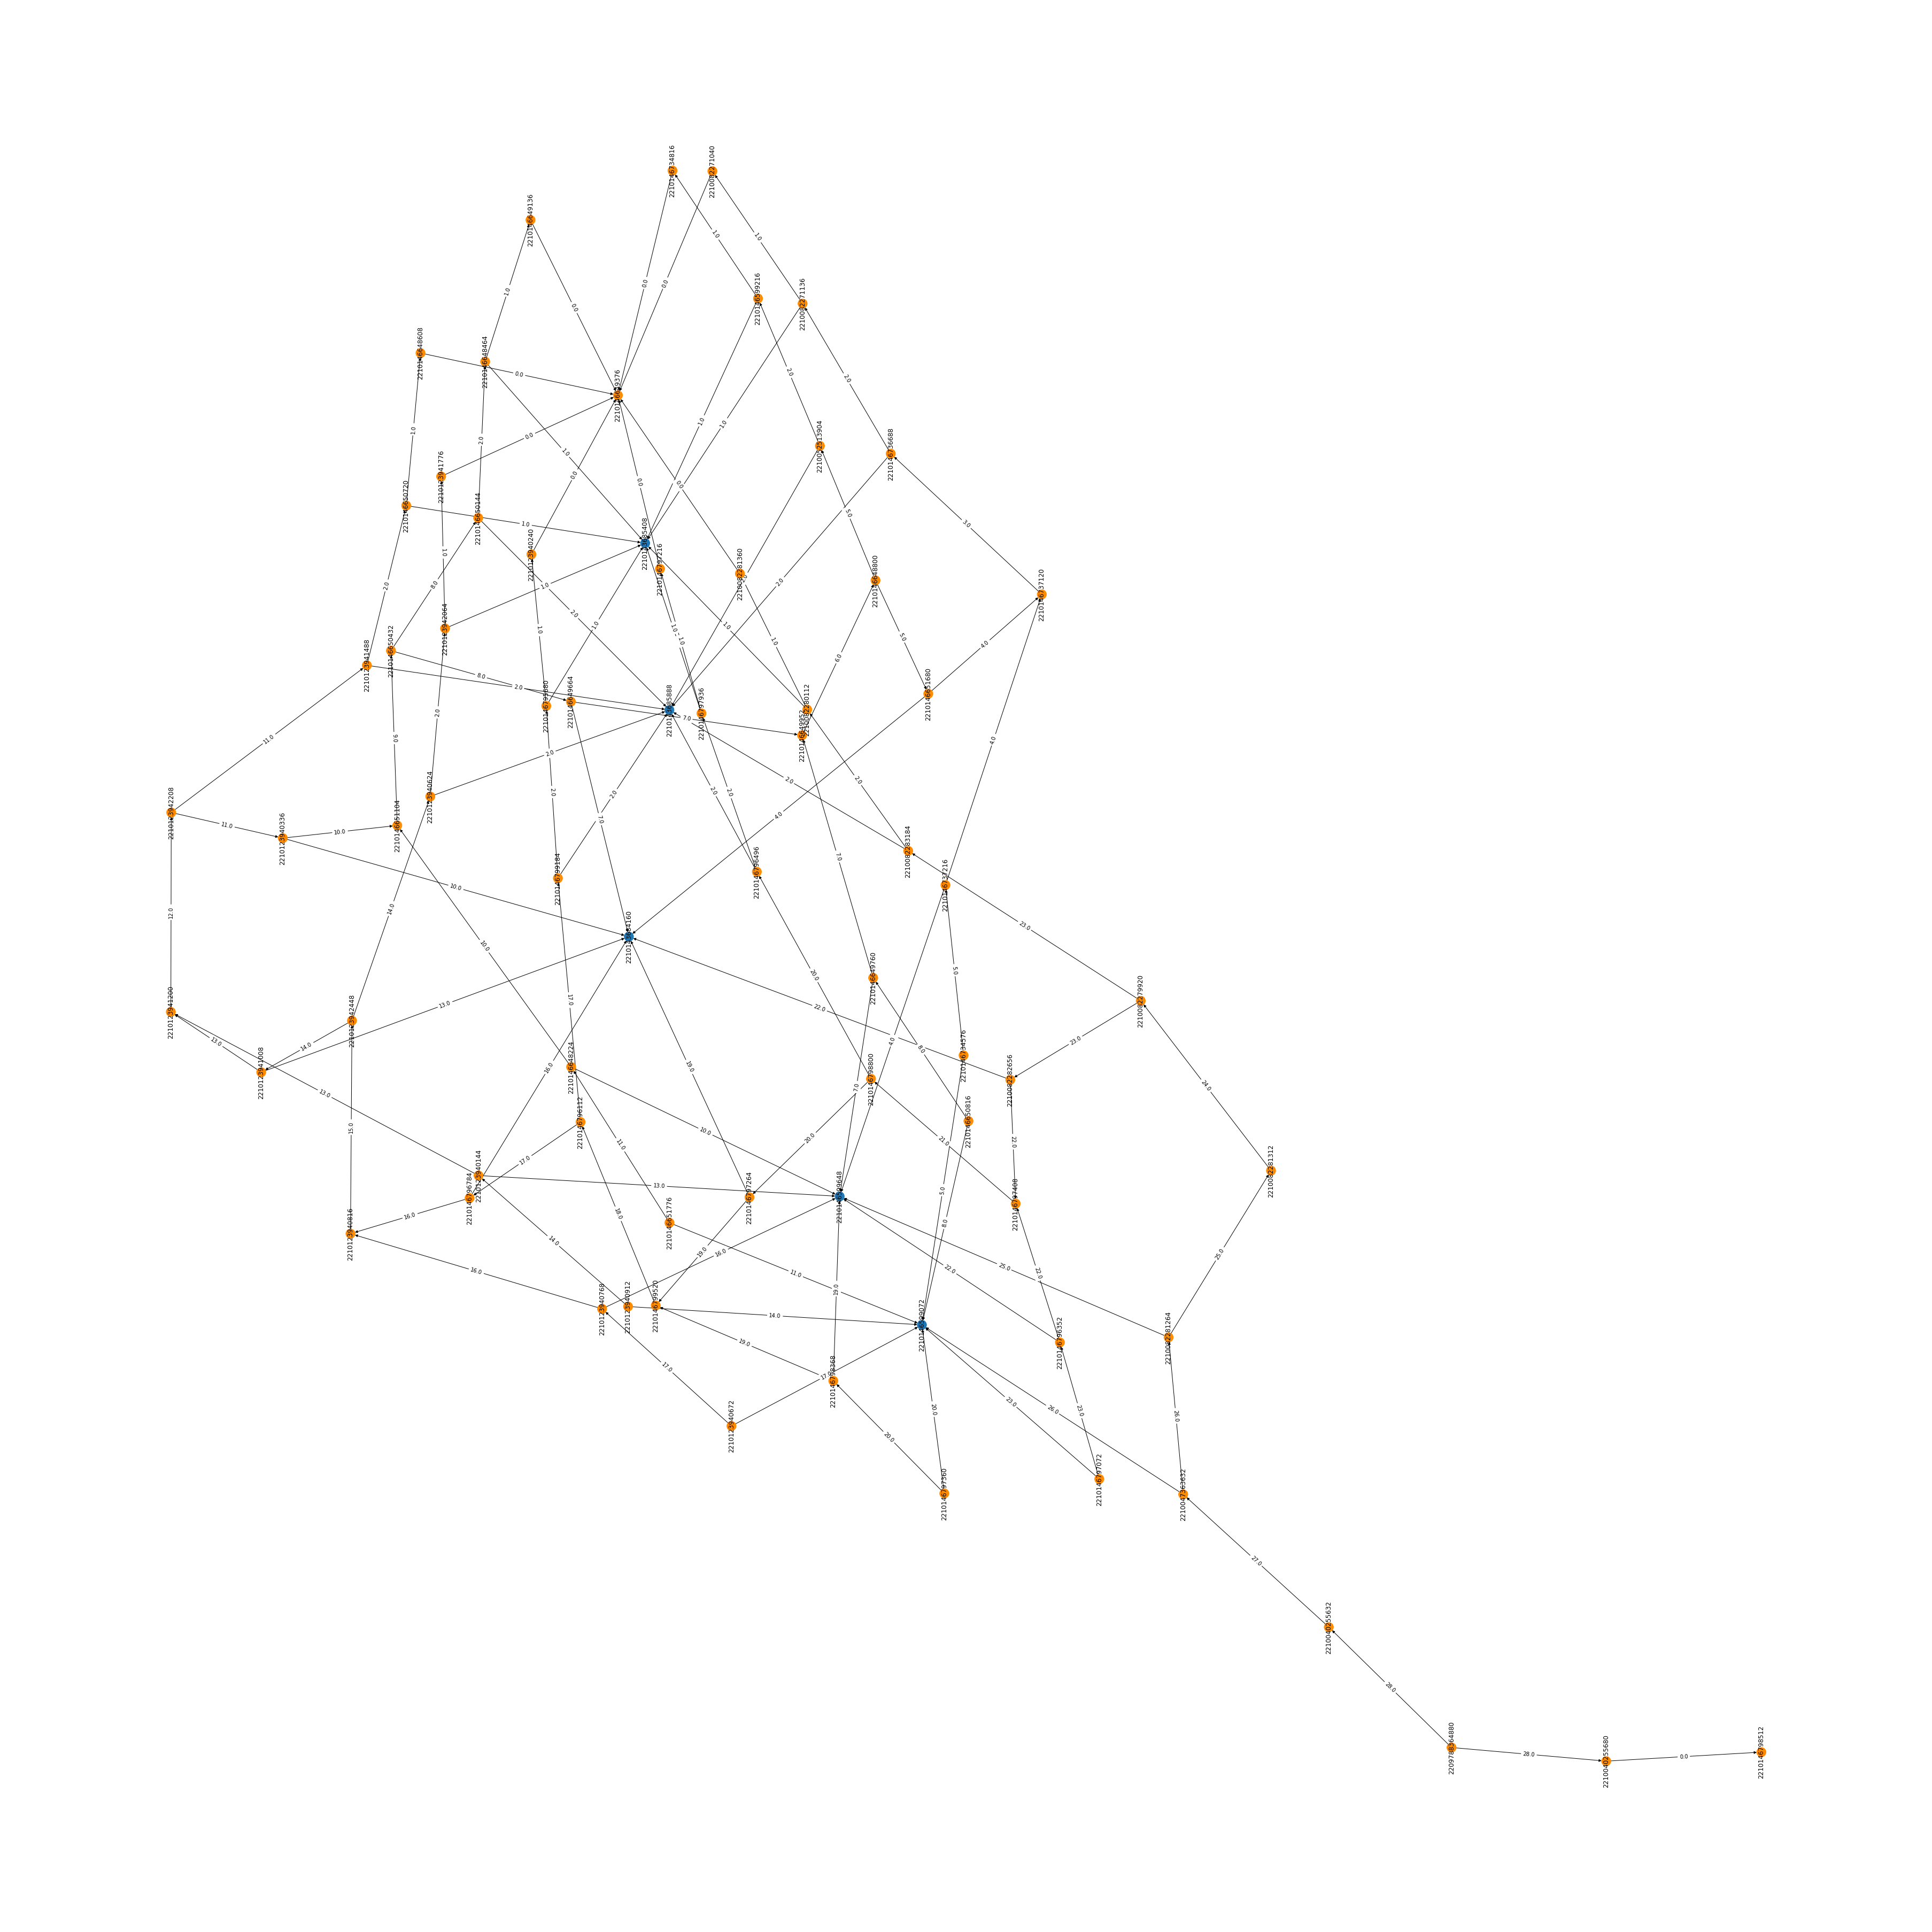

In [194]:
plt.figure(figsize = (50,50))
layout = nx.kamada_kawai_layout(g)
nx.draw(g,
        pos = layout,    
        with_labels = False,
        node_color = type_frame['types'],
        cmap = mpl.colors.ListedColormap(['C0', 'darkorange'])
       )
text = nx.draw_networkx_labels(g, layout)

for _,t in text.items():
    t.set_rotation('vertical')
nx.draw_networkx_edge_labels(g, layout, edge_labels = result)
plt.show()

In [188]:
dict(sorted(tape.gradient_tape.items(), key=lambda x: x[1][2]))

{<nariflow.core.core_tape.Variable at 0x202932b2f40>: (<nariflow.core.shape_function.GetItem at 0x20284562dc0>,
  0),
 <nariflow.core.core_tape.Variable at 0x2029702d2e0>: (<nariflow.core.shape_function.GetItem at 0x2029702dee0>,
  0),
 <nariflow.core.core_tape.Variable at 0x20297018430>: (<nariflow.core.shape_function.GetItem at 0x20297018340>,
  0),
 <nariflow.core.core_tape.Variable at 0x20297018220>: (<nariflow.core.shape_function.GetItem at 0x20297018fd0>,
  0),
 <nariflow.core.core_tape.Variable at 0x20295a70790>: (<nariflow.core.shape_function.GetItem at 0x20295a70a00>,
  0),
 <nariflow.core.core_tape.Variable at 0x20295a70190>: (<nariflow.core.shape_function.GetItem at 0x20295a707f0>,
  0),
 <nariflow.core.core_tape.Variable at 0x2029703c6a0>: (<nariflow.core.shape_function.GetItem at 0x2029703cf10>,
  0),
 <nariflow.core.core_tape.Variable at 0x202932b5790>: (<nariflow.core.shape_function.GetItem at 0x2029703c520>,
  0),
 <nariflow.core.core_tape.Variable at 0x20290aa14c0>: (<

In [100]:
loss

In [ ]:
for epoch in range(100):
    
    for teps in range(len(train_set[0]) - step - 1):
        with GradientTape() as tape:
            y_pred = model(train_set[0][teps  : teps + step])
            loss = f.loss.mean_squared_error(y_pred, train_set[1][(teps + 1) + step])
        
        tape.CalcGradient()
        optimizers.update()
    if epoch % 10 == 0:
        print(loss.data)

In [101]:
tar.data[0]

array([0.07691057, 0.07691057, 0.07691057, 0.07691057, 0.07691057,
       0.07691057, 0.07691057, 0.10997463, 1.34987667, 3.11053757,
       4.53229191, 5.40022334, 5.93751423, 6.18549463, 5.80525801,
       4.89599651, 3.45771014, 1.11016227, 0.07691057, 0.07691057,
       0.07691057, 0.07691057, 0.07691057, 0.07691057])

In [108]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer_tf = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_ware_scaled, Models_dangjin_warehouse)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

TypeError: 'NoneType' object is not callable

In [119]:
Models_dangjin(inp)

<tf.Tensor: shape=(50, 24, 1), dtype=float32, numpy=
array([[[1.4014772e-04],
        [2.6536713e-04],
        [3.2581110e-04],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[1.5443737e-04],
        [2.8483782e-04],
        [3.3628376e-04],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[2.6214676e-04],
        [5.0394132e-04],
        [6.3291285e-04],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[6.2676132e-05],
        [6.5199973e-05],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[3.0917232e-05],
        [1.4885736e-06],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[9.1210211e-05],
        [1.2448066e-04],
        [6.8734051e-05],
        ...,
        [0.0000000e+0

In [52]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer_tf = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_float_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin_float(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_float_scaled, Models_dangjin_floating)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 4.3241 Accuracy 33.1366
Epoch 1 Batch 10 Loss 3.4052 Accuracy 30.5749
Epoch 1 Batch 15 Loss 2.8855 Accuracy 26.7058
Epoch 1 Batch 20 Loss 2.7327 Accuracy 26.0660
Time taken for 1 epoch: 5.57 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 17.8200
Epoch 2 Batch 5 Loss 2.6561 Accuracy 25.1141
Epoch 2 Batch 10 Loss 2.5432 Accuracy 24.1625
Epoch 2 Batch 15 Loss 2.3699 Accuracy 22.6359
Epoch 2 Batch 20 Loss 2.3125 Accuracy 22.7770
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 14.509

Epoch 30 Batch 10 Loss 0.9706 Accuracy 13.8632
Epoch 30 Batch 15 Loss 0.9685 Accuracy 13.8341
Epoch 30 Batch 20 Loss 0.9670 Accuracy 13.8300
Time taken for 1 epoch: 1.23 secs

TestLoss 0.0000 TestAccuracy 9.8921
Epoch 31 Batch 5 Loss 0.9655 Accuracy 13.8280
Epoch 31 Batch 10 Loss 0.9639 Accuracy 13.8049
Epoch 31 Batch 15 Loss 0.9597 Accuracy 13.7738
Epoch 31 Batch 20 Loss 0.9564 Accuracy 13.7474
Time taken for 1 epoch: 1.21 secs

TestLoss 0.0000 TestAccuracy 9.8588
Epoch 32 Batch 5 Loss 0.9545 Accuracy 13.7359
Epoch 32 Batch 10 Loss 0.9536 Accuracy 13.7180
Epoch 32 Batch 15 Loss 0.9505 Accuracy 13.6910
Epoch 32 Batch 20 Loss 0.9487 Accuracy 13.6872
Time taken for 1 epoch: 1.22 secs

TestLoss 0.0000 TestAccuracy 9.8162
Epoch 33 Batch 5 Loss 0.9471 Accuracy 13.6780
Epoch 33 Batch 10 Loss 0.9458 Accuracy 13.6646
Epoch 33 Batch 15 Loss 0.9425 Accuracy 13.6433
Epoch 33 Batch 20 Loss 0.9397 Accuracy 13.6222
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 9.8336
Epoch 34 Batch

Epoch 62 Batch 5 Loss 0.7847 Accuracy 12.4177
Epoch 62 Batch 10 Loss 0.7835 Accuracy 12.4036
Epoch 62 Batch 15 Loss 0.7821 Accuracy 12.3885
Epoch 62 Batch 20 Loss 0.7811 Accuracy 12.3798
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 9.8841
Epoch 63 Batch 5 Loss 0.7810 Accuracy 12.3854
Epoch 63 Batch 10 Loss 0.7798 Accuracy 12.3707
Epoch 63 Batch 15 Loss 0.7784 Accuracy 12.3547
Epoch 63 Batch 20 Loss 0.7774 Accuracy 12.3467
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 9.9168
Epoch 64 Batch 5 Loss 0.7771 Accuracy 12.3501
Epoch 64 Batch 10 Loss 0.7759 Accuracy 12.3372
Epoch 64 Batch 15 Loss 0.7747 Accuracy 12.3229
Epoch 64 Batch 20 Loss 0.7737 Accuracy 12.3135
Time taken for 1 epoch: 1.21 secs

TestLoss 0.0000 TestAccuracy 9.9114
Epoch 65 Batch 5 Loss 0.7736 Accuracy 12.3193
Epoch 65 Batch 10 Loss 0.7724 Accuracy 12.3069
Epoch 65 Batch 15 Loss 0.7711 Accuracy 12.2929
Epoch 65 Batch 20 Loss 0.7704 Accuracy 12.2862
Time taken for 1 epoch: 1.25 secs

Test

Epoch 94 Batch 5 Loss 0.6930 Accuracy 11.5890
Epoch 94 Batch 10 Loss 0.6923 Accuracy 11.5825
Epoch 94 Batch 15 Loss 0.6915 Accuracy 11.5722
Epoch 94 Batch 20 Loss 0.6911 Accuracy 11.5670
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 10.1886
Epoch 95 Batch 5 Loss 0.6908 Accuracy 11.5682
Epoch 95 Batch 10 Loss 0.6901 Accuracy 11.5616
Epoch 95 Batch 15 Loss 0.6894 Accuracy 11.5531
Epoch 95 Batch 20 Loss 0.6889 Accuracy 11.5470
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 10.1897
Epoch 96 Batch 5 Loss 0.6887 Accuracy 11.5489
Epoch 96 Batch 10 Loss 0.6880 Accuracy 11.5420
Epoch 96 Batch 15 Loss 0.6873 Accuracy 11.5327
Epoch 96 Batch 20 Loss 0.6868 Accuracy 11.5257
Time taken for 1 epoch: 1.22 secs

TestLoss 0.0000 TestAccuracy 10.1985
Epoch 97 Batch 5 Loss 0.6866 Accuracy 11.5281
Epoch 97 Batch 10 Loss 0.6859 Accuracy 11.5211
Epoch 97 Batch 15 Loss 0.6852 Accuracy 11.5128
Epoch 97 Batch 20 Loss 0.6848 Accuracy 11.5088
Time taken for 1 epoch: 1.19 secs

T

Epoch 125 Batch 15 Loss 0.6385 Accuracy 11.0743
Epoch 125 Batch 20 Loss 0.6381 Accuracy 11.0680
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 10.2901
Epoch 126 Batch 5 Loss 0.6379 Accuracy 11.0689
Epoch 126 Batch 10 Loss 0.6374 Accuracy 11.0645
Epoch 126 Batch 15 Loss 0.6368 Accuracy 11.0578
Epoch 126 Batch 20 Loss 0.6366 Accuracy 11.0525
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 10.3007
Epoch 127 Batch 5 Loss 0.6363 Accuracy 11.0533
Epoch 127 Batch 10 Loss 0.6359 Accuracy 11.0490
Epoch 127 Batch 15 Loss 0.6353 Accuracy 11.0433
Epoch 127 Batch 20 Loss 0.6350 Accuracy 11.0382
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 10.2969
Epoch 128 Batch 5 Loss 0.6349 Accuracy 11.0402
Epoch 128 Batch 10 Loss 0.6344 Accuracy 11.0357
Epoch 128 Batch 15 Loss 0.6339 Accuracy 11.0296
Epoch 128 Batch 20 Loss 0.6335 Accuracy 11.0238
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 10.2924
Epoch 129 Batch 5 Loss 0.6334 Accuracy 11.0

Epoch 156 Batch 20 Loss 0.6021 Accuracy 10.7271
Time taken for 1 epoch: 1.24 secs

TestLoss 0.0000 TestAccuracy 10.4280
Epoch 157 Batch 5 Loss 0.6020 Accuracy 10.7295
Epoch 157 Batch 10 Loss 0.6017 Accuracy 10.7270
Epoch 157 Batch 15 Loss 0.6013 Accuracy 10.7224
Epoch 157 Batch 20 Loss 0.6012 Accuracy 10.7196
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 10.4282
Epoch 158 Batch 5 Loss 0.6009 Accuracy 10.7181
Epoch 158 Batch 10 Loss 0.6006 Accuracy 10.7145
Epoch 158 Batch 15 Loss 0.6002 Accuracy 10.7101
Epoch 158 Batch 20 Loss 0.5999 Accuracy 10.7064
Time taken for 1 epoch: 1.23 secs

TestLoss 0.0000 TestAccuracy 10.4237
Epoch 159 Batch 5 Loss 0.5999 Accuracy 10.7084
Epoch 159 Batch 10 Loss 0.5995 Accuracy 10.7050
Epoch 159 Batch 15 Loss 0.5992 Accuracy 10.7004
Epoch 159 Batch 20 Loss 0.5990 Accuracy 10.6984
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 10.4302
Epoch 160 Batch 5 Loss 0.5989 Accuracy 10.6987
Epoch 160 Batch 10 Loss 0.5985 Accuracy 10.6

Epoch 188 Batch 5 Loss 0.5724 Accuracy 10.4411
Epoch 188 Batch 10 Loss 0.5721 Accuracy 10.4393
Epoch 188 Batch 15 Loss 0.5718 Accuracy 10.4359
Epoch 188 Batch 20 Loss 0.5717 Accuracy 10.4331
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 10.4727
Epoch 189 Batch 5 Loss 0.5716 Accuracy 10.4342
Epoch 189 Batch 10 Loss 0.5713 Accuracy 10.4317
Epoch 189 Batch 15 Loss 0.5711 Accuracy 10.4283
Epoch 189 Batch 20 Loss 0.5710 Accuracy 10.4275
Time taken for 1 epoch: 1.22 secs

TestLoss 0.0000 TestAccuracy 10.4697
Epoch 190 Batch 5 Loss 0.5709 Accuracy 10.4282
Epoch 190 Batch 10 Loss 0.5707 Accuracy 10.4257
Epoch 190 Batch 15 Loss 0.5704 Accuracy 10.4217
Epoch 190 Batch 20 Loss 0.5702 Accuracy 10.4190
Time taken for 1 epoch: 1.25 secs

TestLoss 0.0000 TestAccuracy 10.4662
Epoch 191 Batch 5 Loss 0.5701 Accuracy 10.4194
Epoch 191 Batch 10 Loss 0.5698 Accuracy 10.4165
Epoch 191 Batch 15 Loss 0.5695 Accuracy 10.4129
Epoch 191 Batch 20 Loss 0.5694 Accuracy 10.4103
Time taken for 1 epo

In [53]:
capacity = 500
train_max = train_max_ulsan.copy()
train_min = train_min_ulsan.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_ulsan_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_ulsan_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_ulsan(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_ulsan_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_ulsan_scaled, y_test_ulsan_scaled, Models_ulsan)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 1.3024 Accuracy 31.0924
Epoch 1 Batch 10 Loss 1.1129 Accuracy 32.4122
Epoch 1 Batch 15 Loss 0.9977 Accuracy 32.2828
Epoch 1 Batch 20 Loss 0.9806 Accuracy 30.0477
Time taken for 1 epoch: 5.61 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 28.0032
Epoch 2 Batch 5 Loss 0.9371 Accuracy 29.2473
Epoch 2 Batch 10 Loss 0.9041 Accuracy 29.0418
Epoch 2 Batch 15 Loss 0.8653 Accuracy 27.7879
Epoch 2 Batch 20 Loss 0.8488 Accuracy 27.0748
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 26.404

Epoch 30 Batch 10 Loss 0.2612 Accuracy 13.1284
Epoch 30 Batch 15 Loss 0.2602 Accuracy 13.1055
Epoch 30 Batch 20 Loss 0.2594 Accuracy 13.0780
Time taken for 1 epoch: 1.17 secs

TestLoss 0.0000 TestAccuracy 10.4764
Epoch 31 Batch 5 Loss 0.2583 Accuracy 13.0413
Epoch 31 Batch 10 Loss 0.2572 Accuracy 13.0155
Epoch 31 Batch 15 Loss 0.2564 Accuracy 12.9963
Epoch 31 Batch 20 Loss 0.2557 Accuracy 12.9712
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 10.3957
Epoch 32 Batch 5 Loss 0.2546 Accuracy 12.9354
Epoch 32 Batch 10 Loss 0.2535 Accuracy 12.9113
Epoch 32 Batch 15 Loss 0.2527 Accuracy 12.8918
Epoch 32 Batch 20 Loss 0.2521 Accuracy 12.8712
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 10.3360
Epoch 33 Batch 5 Loss 0.2510 Accuracy 12.8317
Epoch 33 Batch 10 Loss 0.2500 Accuracy 12.8093
Epoch 33 Batch 15 Loss 0.2493 Accuracy 12.7923
Epoch 33 Batch 20 Loss 0.2486 Accuracy 12.7697
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 10.2753
Epoch 34 B

Epoch 62 Batch 5 Loss 0.1944 Accuracy 11.1857
Epoch 62 Batch 10 Loss 0.1940 Accuracy 11.1767
Epoch 62 Batch 15 Loss 0.1937 Accuracy 11.1705
Epoch 62 Batch 20 Loss 0.1936 Accuracy 11.1631
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 9.3454
Epoch 63 Batch 5 Loss 0.1933 Accuracy 11.1553
Epoch 63 Batch 10 Loss 0.1930 Accuracy 11.1466
Epoch 63 Batch 15 Loss 0.1927 Accuracy 11.1409
Epoch 63 Batch 20 Loss 0.1926 Accuracy 11.1363
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 9.3382
Epoch 64 Batch 5 Loss 0.1923 Accuracy 11.1250
Epoch 64 Batch 10 Loss 0.1919 Accuracy 11.1147
Epoch 64 Batch 15 Loss 0.1916 Accuracy 11.1063
Epoch 64 Batch 20 Loss 0.1915 Accuracy 11.0994
Time taken for 1 epoch: 1.32 secs

TestLoss 0.0000 TestAccuracy 9.3210
Epoch 65 Batch 5 Loss 0.1911 Accuracy 11.0881
Epoch 65 Batch 10 Loss 0.1908 Accuracy 11.0784
Epoch 65 Batch 15 Loss 0.1905 Accuracy 11.0720
Epoch 65 Batch 20 Loss 0.1904 Accuracy 11.0666
Time taken for 1 epoch: 1.21 secs

Test

Epoch 94 Batch 5 Loss 0.1694 Accuracy 10.4317
Epoch 94 Batch 10 Loss 0.1692 Accuracy 10.4260
Epoch 94 Batch 15 Loss 0.1690 Accuracy 10.4229
Epoch 94 Batch 20 Loss 0.1690 Accuracy 10.4200
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 9.0439
Epoch 95 Batch 5 Loss 0.1688 Accuracy 10.4143
Epoch 95 Batch 10 Loss 0.1686 Accuracy 10.4087
Epoch 95 Batch 15 Loss 0.1685 Accuracy 10.4048
Epoch 95 Batch 20 Loss 0.1684 Accuracy 10.4012
Time taken for 1 epoch: 1.21 secs

TestLoss 0.0000 TestAccuracy 9.0268
Epoch 96 Batch 5 Loss 0.1682 Accuracy 10.3953
Epoch 96 Batch 10 Loss 0.1680 Accuracy 10.3896
Epoch 96 Batch 15 Loss 0.1679 Accuracy 10.3855
Epoch 96 Batch 20 Loss 0.1678 Accuracy 10.3825
Time taken for 1 epoch: 1.21 secs

TestLoss 0.0000 TestAccuracy 9.0189
Epoch 97 Batch 5 Loss 0.1676 Accuracy 10.3756
Epoch 97 Batch 10 Loss 0.1674 Accuracy 10.3703
Epoch 97 Batch 15 Loss 0.1673 Accuracy 10.3672
Epoch 97 Batch 20 Loss 0.1672 Accuracy 10.3643
Time taken for 1 epoch: 1.19 secs

Test

Epoch 125 Batch 15 Loss 0.1555 Accuracy 10.0073
Epoch 125 Batch 20 Loss 0.1556 Accuracy 10.0062
Time taken for 1 epoch: 1.24 secs

TestLoss 0.0000 TestAccuracy 8.8049
Epoch 126 Batch 5 Loss 0.1555 Accuracy 10.0038
Epoch 126 Batch 10 Loss 0.1553 Accuracy 10.0001
Epoch 126 Batch 15 Loss 0.1552 Accuracy 9.9977
Epoch 126 Batch 20 Loss 0.1552 Accuracy 9.9947
Time taken for 1 epoch: 1.21 secs

TestLoss 0.0000 TestAccuracy 8.7892
Epoch 127 Batch 5 Loss 0.1551 Accuracy 9.9923
Epoch 127 Batch 10 Loss 0.1550 Accuracy 9.9891
Epoch 127 Batch 15 Loss 0.1549 Accuracy 9.9862
Epoch 127 Batch 20 Loss 0.1549 Accuracy 9.9852
Time taken for 1 epoch: 1.20 secs

TestLoss 0.0000 TestAccuracy 8.7864
Epoch 128 Batch 5 Loss 0.1547 Accuracy 9.9796
Epoch 128 Batch 10 Loss 0.1546 Accuracy 9.9764
Epoch 128 Batch 15 Loss 0.1545 Accuracy 9.9754
Epoch 128 Batch 20 Loss 0.1545 Accuracy 9.9731
Time taken for 1 epoch: 1.21 secs

TestLoss 0.0000 TestAccuracy 8.7691
Epoch 129 Batch 5 Loss 0.1544 Accuracy 9.9701
Epoch 129 B

Epoch 157 Batch 10 Loss 0.1469 Accuracy 9.7360
Epoch 157 Batch 15 Loss 0.1469 Accuracy 9.7356
Epoch 157 Batch 20 Loss 0.1469 Accuracy 9.7342
Time taken for 1 epoch: 1.18 secs

TestLoss 0.0000 TestAccuracy 8.6313
Epoch 158 Batch 5 Loss 0.1468 Accuracy 9.7316
Epoch 158 Batch 10 Loss 0.1467 Accuracy 9.7291
Epoch 158 Batch 15 Loss 0.1466 Accuracy 9.7287
Epoch 158 Batch 20 Loss 0.1466 Accuracy 9.7271
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 8.6208
Epoch 159 Batch 5 Loss 0.1466 Accuracy 9.7248
Epoch 159 Batch 10 Loss 0.1465 Accuracy 9.7218
Epoch 159 Batch 15 Loss 0.1464 Accuracy 9.7197
Epoch 159 Batch 20 Loss 0.1464 Accuracy 9.7177
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 8.6101
Epoch 160 Batch 5 Loss 0.1463 Accuracy 9.7145
Epoch 160 Batch 10 Loss 0.1462 Accuracy 9.7122
Epoch 160 Batch 15 Loss 0.1461 Accuracy 9.7107
Epoch 160 Batch 20 Loss 0.1461 Accuracy 9.7088
Time taken for 1 epoch: 1.19 secs

TestLoss 0.0000 TestAccuracy 8.6002
Epoch 161 Batc

Epoch 189 Batch 5 Loss 0.1405 Accuracy 9.5353
Epoch 189 Batch 10 Loss 0.1404 Accuracy 9.5336
Epoch 189 Batch 15 Loss 0.1404 Accuracy 9.5321
Epoch 189 Batch 20 Loss 0.1404 Accuracy 9.5315
Time taken for 1 epoch: 1.28 secs

TestLoss 0.0000 TestAccuracy 8.4799
Epoch 190 Batch 5 Loss 0.1403 Accuracy 9.5283
Epoch 190 Batch 10 Loss 0.1402 Accuracy 9.5267
Epoch 190 Batch 15 Loss 0.1402 Accuracy 9.5264
Epoch 190 Batch 20 Loss 0.1402 Accuracy 9.5257
Time taken for 1 epoch: 1.23 secs

TestLoss 0.0000 TestAccuracy 8.4754
Epoch 191 Batch 5 Loss 0.1401 Accuracy 9.5233
Epoch 191 Batch 10 Loss 0.1401 Accuracy 9.5217
Epoch 191 Batch 15 Loss 0.1400 Accuracy 9.5220
Epoch 191 Batch 20 Loss 0.1401 Accuracy 9.5202
Time taken for 1 epoch: 1.23 secs

TestLoss 0.0000 TestAccuracy 8.4697
Epoch 192 Batch 5 Loss 0.1400 Accuracy 9.5198
Epoch 192 Batch 10 Loss 0.1400 Accuracy 9.5195
Epoch 192 Batch 15 Loss 0.1399 Accuracy 9.5187
Epoch 192 Batch 20 Loss 0.1399 Accuracy 9.5184
Time taken for 1 epoch: 1.23 secs

Test

## 3) CNN-LSTM

### (1) min_max scale

#### - 당진

In [34]:
train_min_dangjin = np.min(X_train_dangjin)
train_max_dangjin = np.max(X_train_dangjin)

X_train_dangjin_scaled = (X_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

X_test_dangjin_scaled = (X_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

X_train_dangjin_scaled[:,:,5] = X_train_dangjin[:,:,5]

X_test_dangjin_scaled[:,:,5] = X_test_dangjin[:,:,5]

In [35]:
y_train_dangjin_scaled = (y_train_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_scaled = (y_test_dangjin - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [36]:
y_train_dangjin_ware_scaled = (y_train_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_ware_scaled = (y_test_dangjin_ware - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

In [37]:
y_train_dangjin_float_scaled = (y_train_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

y_test_dangjin_float_scaled = (y_test_dangjin_float - train_min_dangjin) / (train_max_dangjin - train_min_dangjin)

#### - 울산

In [38]:
train_min_ulsan = np.min(X_train_ulsan)
train_max_ulsan = np.max(X_train_ulsan)

X_train_ulsan_scaled = (X_train_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

X_test_ulsan_scaled = (X_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

X_train_ulsan_scaled[:,:,5] = X_train_ulsan[:,:,5]

X_test_ulsan_scaled[:,:,5] = X_test_ulsan[:,:,5]

In [39]:
y_train_ulsan_scaled = (y_train_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

y_test_ulsan_scaled = (y_test_ulsan - train_min_ulsan) / (train_max_ulsan - train_min_ulsan)

### (2) 모델 구성

In [40]:
class TrainModel(tf.keras.Model):
    def __init__(self, 
                 kernel_size, 
                 lstm_dim):
        
        super(TrainModel, self).__init__()

        self.kernel_size = kernel_size
        self.lstm_dim = lstm_dim
     
    def build(self, input_shape):
    
        self.conv = tf.keras.layers.Dense(self.kernel_size, 
                                      activation = "relu")
        
        self.conv_2 = tf.keras.layers.Dense(self.kernel_size, 
                                      activation = "relu")
        
        self.lstm = tf.keras.layers.LSTM(self.lstm_dim,
                                        return_sequences = True)
        
        self.concat = tf.keras.layers.Add()
        
        self.dropout = tf.keras.layers.Dropout(0.2)
        
        output_layer = tf.keras.layers.Dense(1, activation = "relu")
        
        self.outputs = tf.keras.layers.TimeDistributed(output_layer)
    
    def call(self, input_tensor):
        
        
        conv_output = self.conv(input_tensor)
        conv_output = self.dropout(conv_output)
        conv_output = self.conv_2(conv_output)
        conv_output = self.dropout(conv_output)
        
        lstm_output_1 = self.lstm(conv_output)
        
        output = self.outputs(lstm_output_1)
        
        return output

### (3) 모델 컴파일

#### - 학습 스케쥴러 정의

In [70]:
Models_dangjin = TrainModel(
                     kernel_size = 200, 
                      lstm_dim = 256)

Models_dangjin_warehouse = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_ulsan = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

Models_dangjin_floating = TrainModel(
                      kernel_size = 200, 
                      lstm_dim = 256)

In [71]:
def nmae_10(y_true, y_pred):
    
    y_true = y_true * (train_max - train_min) + train_min
    y_pred = y_pred * (train_max - train_min) + train_min
    
    absolute_error = abs(y_true - y_pred)
    absolute_error = absolute_error / capacity
    
    target_idx = np.where(y_true >= capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx]
    
    return nmae

In [72]:
@tf.function()
def train_step_dangjin(inp , tar):
    with tf.GradientTape() as tape:
        
        output = Models_dangjin(inp)

        loss =  loss_function(tar, output)
    
    gradients = tape.gradient(loss, Models_dangjin.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [73]:
@tf.function()
def train_step_dangjin_floating(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_dangjin_floating(inp)

        loss =  loss_function(tar, output)
 
    gradients = tape.gradient(loss, Models_dangjin_floating.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin_floating.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [74]:
@tf.function()
def train_step_dangjin_warehouse(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_dangjin_warehouse(inp)

        loss =  loss_function(tar, output)
 
    gradients = tape.gradient(loss, Models_dangjin_warehouse.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_dangjin_warehouse.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [75]:
@tf.function()
def train_step_ulsan(inp , tar):
    with tf.GradientTape() as tape:
        output = Models_ulsan(inp)

        loss =  loss_function(tar, output)
 
    gradients = tape.gradient(loss, Models_ulsan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, Models_ulsan.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [76]:
def val_accuracy(inp, tar, Models):
    output = Models(inp)
    
    test_accuracy(tf.numpy_function(nmae_10, 
                                     [tar, tf.squeeze(output, -1)], 
                                     tf.float32))

In [77]:
EPOCHS = 300
batch_size = 50

#### - dangjin

In [50]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_scaled, Models_dangjin)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.0225 Accuracy 29.1710
Epoch 1 Batch 10 Loss 0.0175 Accuracy 32.9480
Epoch 1 Batch 15 Loss 0.0145 Accuracy 27.1681
Epoch 1 Batch 20 Loss 0.0127 Accuracy 25.8063
Time taken for 1 epoch: 1.69 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 21.1337
Epoch 2 Batch 5 Loss 0.0116 Accuracy 24.9597
Epoch 2 Batch 10 Loss 0.0109 Accuracy 23.9365
Epoch 2 Batch 15 Loss 0.0100 Accuracy 22.5892
Epoch 2 Batch 20 Loss 0.0096 Accuracy 22.5278
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 18.331

Epoch 30 Batch 10 Loss 0.0043 Accuracy 14.9345
Epoch 30 Batch 15 Loss 0.0043 Accuracy 14.9067
Epoch 30 Batch 20 Loss 0.0043 Accuracy 14.9247
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 13.5189
Epoch 31 Batch 5 Loss 0.0042 Accuracy 14.9344
Epoch 31 Batch 10 Loss 0.0042 Accuracy 14.9184
Epoch 31 Batch 15 Loss 0.0042 Accuracy 14.8925
Epoch 31 Batch 20 Loss 0.0042 Accuracy 14.9085
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 13.5325
Epoch 32 Batch 5 Loss 0.0042 Accuracy 14.9189
Epoch 32 Batch 10 Loss 0.0042 Accuracy 14.9048
Epoch 32 Batch 15 Loss 0.0042 Accuracy 14.8811
Epoch 32 Batch 20 Loss 0.0042 Accuracy 14.8952
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 13.5461
Epoch 33 Batch 5 Loss 0.0042 Accuracy 14.9062
Epoch 33 Batch 10 Loss 0.0042 Accuracy 14.8935
Epoch 33 Batch 15 Loss 0.0042 Accuracy 14.8720
Epoch 33 Batch 20 Loss 0.0042 Accuracy 14.8826
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 13.5566
Epoch 34 B

Epoch 62 Batch 10 Loss 0.0039 Accuracy 14.4777
Epoch 62 Batch 15 Loss 0.0039 Accuracy 14.4688
Epoch 62 Batch 20 Loss 0.0039 Accuracy 14.4729
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 13.4847
Epoch 63 Batch 5 Loss 0.0038 Accuracy 14.4668
Epoch 63 Batch 10 Loss 0.0038 Accuracy 14.4596
Epoch 63 Batch 15 Loss 0.0038 Accuracy 14.4509
Epoch 63 Batch 20 Loss 0.0038 Accuracy 14.4548
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 13.4748
Epoch 64 Batch 5 Loss 0.0038 Accuracy 14.4483
Epoch 64 Batch 10 Loss 0.0038 Accuracy 14.4412
Epoch 64 Batch 15 Loss 0.0038 Accuracy 14.4327
Epoch 64 Batch 20 Loss 0.0038 Accuracy 14.4362
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 13.4643
Epoch 65 Batch 5 Loss 0.0038 Accuracy 14.4295
Epoch 65 Batch 10 Loss 0.0038 Accuracy 14.4225
Epoch 65 Batch 15 Loss 0.0038 Accuracy 14.4142
Epoch 65 Batch 20 Loss 0.0038 Accuracy 14.4167
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 13.4525
Epoch 66 B

Epoch 94 Batch 10 Loss 0.0035 Accuracy 13.8566
Epoch 94 Batch 15 Loss 0.0035 Accuracy 13.8534
Epoch 94 Batch 20 Loss 0.0035 Accuracy 13.8506
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 13.0239
Epoch 95 Batch 5 Loss 0.0035 Accuracy 13.8442
Epoch 95 Batch 10 Loss 0.0035 Accuracy 13.8391
Epoch 95 Batch 15 Loss 0.0035 Accuracy 13.8363
Epoch 95 Batch 20 Loss 0.0035 Accuracy 13.8333
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 13.0028
Epoch 96 Batch 5 Loss 0.0035 Accuracy 13.8273
Epoch 96 Batch 10 Loss 0.0035 Accuracy 13.8220
Epoch 96 Batch 15 Loss 0.0035 Accuracy 13.8190
Epoch 96 Batch 20 Loss 0.0035 Accuracy 13.8157
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 12.9813
Epoch 97 Batch 5 Loss 0.0035 Accuracy 13.8095
Epoch 97 Batch 10 Loss 0.0035 Accuracy 13.8041
Epoch 97 Batch 15 Loss 0.0034 Accuracy 13.8004
Epoch 97 Batch 20 Loss 0.0034 Accuracy 13.7974
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 12.9605
Epoch 98 B

Epoch 125 Batch 20 Loss 0.0032 Accuracy 13.3168
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 12.4327
Epoch 126 Batch 5 Loss 0.0032 Accuracy 13.3123
Epoch 126 Batch 10 Loss 0.0032 Accuracy 13.3081
Epoch 126 Batch 15 Loss 0.0032 Accuracy 13.3036
Epoch 126 Batch 20 Loss 0.0032 Accuracy 13.3005
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 12.4181
Epoch 127 Batch 5 Loss 0.0032 Accuracy 13.2961
Epoch 127 Batch 10 Loss 0.0032 Accuracy 13.2919
Epoch 127 Batch 15 Loss 0.0032 Accuracy 13.2874
Epoch 127 Batch 20 Loss 0.0032 Accuracy 13.2842
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 12.4037
Epoch 128 Batch 5 Loss 0.0032 Accuracy 13.2799
Epoch 128 Batch 10 Loss 0.0032 Accuracy 13.2758
Epoch 128 Batch 15 Loss 0.0032 Accuracy 13.2713
Epoch 128 Batch 20 Loss 0.0032 Accuracy 13.2681
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 12.3895
Epoch 129 Batch 5 Loss 0.0032 Accuracy 13.2639
Epoch 129 Batch 10 Loss 0.0032 Accuracy 13.2

Epoch 157 Batch 10 Loss 0.0030 Accuracy 12.8621
Epoch 157 Batch 15 Loss 0.0030 Accuracy 12.8581
Epoch 157 Batch 20 Loss 0.0030 Accuracy 12.8556
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 12.0492
Epoch 158 Batch 5 Loss 0.0030 Accuracy 12.8527
Epoch 158 Batch 10 Loss 0.0030 Accuracy 12.8500
Epoch 158 Batch 15 Loss 0.0030 Accuracy 12.8460
Epoch 158 Batch 20 Loss 0.0030 Accuracy 12.8435
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 12.0413
Epoch 159 Batch 5 Loss 0.0030 Accuracy 12.8406
Epoch 159 Batch 10 Loss 0.0030 Accuracy 12.8380
Epoch 159 Batch 15 Loss 0.0030 Accuracy 12.8340
Epoch 159 Batch 20 Loss 0.0030 Accuracy 12.8315
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 12.0336
Epoch 160 Batch 5 Loss 0.0030 Accuracy 12.8287
Epoch 160 Batch 10 Loss 0.0030 Accuracy 12.8261
Epoch 160 Batch 15 Loss 0.0030 Accuracy 12.8222
Epoch 160 Batch 20 Loss 0.0030 Accuracy 12.8197
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 12.

Epoch 188 Batch 20 Loss 0.0028 Accuracy 12.5224
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 11.8119
Epoch 189 Batch 5 Loss 0.0028 Accuracy 12.5201
Epoch 189 Batch 10 Loss 0.0028 Accuracy 12.5177
Epoch 189 Batch 15 Loss 0.0028 Accuracy 12.5148
Epoch 189 Batch 20 Loss 0.0028 Accuracy 12.5127
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.8048
Epoch 190 Batch 5 Loss 0.0028 Accuracy 12.5107
Epoch 190 Batch 10 Loss 0.0028 Accuracy 12.5083
Epoch 190 Batch 15 Loss 0.0028 Accuracy 12.5053
Epoch 190 Batch 20 Loss 0.0028 Accuracy 12.5033
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.7976
Epoch 191 Batch 5 Loss 0.0028 Accuracy 12.5015
Epoch 191 Batch 10 Loss 0.0028 Accuracy 12.4991
Epoch 191 Batch 15 Loss 0.0028 Accuracy 12.4960
Epoch 191 Batch 20 Loss 0.0028 Accuracy 12.4947
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.7912
Epoch 192 Batch 5 Loss 0.0028 Accuracy 12.4926
Epoch 192 Batch 10 Loss 0.0028 Accuracy 12.4

Epoch 220 Batch 10 Loss 0.0027 Accuracy 12.2694
Epoch 220 Batch 15 Loss 0.0027 Accuracy 12.2668
Epoch 220 Batch 20 Loss 0.0027 Accuracy 12.2654
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.6222
Epoch 221 Batch 5 Loss 0.0027 Accuracy 12.2641
Epoch 221 Batch 10 Loss 0.0027 Accuracy 12.2622
Epoch 221 Batch 15 Loss 0.0027 Accuracy 12.2595
Epoch 221 Batch 20 Loss 0.0027 Accuracy 12.2587
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.6170
Epoch 222 Batch 5 Loss 0.0027 Accuracy 12.2571
Epoch 222 Batch 10 Loss 0.0027 Accuracy 12.2553
Epoch 222 Batch 15 Loss 0.0027 Accuracy 12.2527
Epoch 222 Batch 20 Loss 0.0027 Accuracy 12.2514
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 11.6124
Epoch 223 Batch 5 Loss 0.0027 Accuracy 12.2502
Epoch 223 Batch 10 Loss 0.0027 Accuracy 12.2483
Epoch 223 Batch 15 Loss 0.0027 Accuracy 12.2457
Epoch 223 Batch 20 Loss 0.0027 Accuracy 12.2448
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.

Epoch 251 Batch 20 Loss 0.0026 Accuracy 12.0756
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 11.5009
Epoch 252 Batch 5 Loss 0.0026 Accuracy 12.0742
Epoch 252 Batch 10 Loss 0.0026 Accuracy 12.0726
Epoch 252 Batch 15 Loss 0.0026 Accuracy 12.0702
Epoch 252 Batch 20 Loss 0.0026 Accuracy 12.0700
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 11.4976
Epoch 253 Batch 5 Loss 0.0026 Accuracy 12.0684
Epoch 253 Batch 10 Loss 0.0026 Accuracy 12.0669
Epoch 253 Batch 15 Loss 0.0026 Accuracy 12.0645
Epoch 253 Batch 20 Loss 0.0026 Accuracy 12.0640
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 11.4937
Epoch 254 Batch 5 Loss 0.0026 Accuracy 12.0624
Epoch 254 Batch 10 Loss 0.0026 Accuracy 12.0608
Epoch 254 Batch 15 Loss 0.0026 Accuracy 12.0585
Epoch 254 Batch 20 Loss 0.0026 Accuracy 12.0575
Time taken for 1 epoch: 0.55 secs

TestLoss 0.0000 TestAccuracy 11.4907
Epoch 255 Batch 5 Loss 0.0026 Accuracy 12.0561
Epoch 255 Batch 10 Loss 0.0026 Accuracy 12.0

Epoch 283 Batch 10 Loss 0.0025 Accuracy 11.9397
Epoch 283 Batch 15 Loss 0.0025 Accuracy 11.9378
Epoch 283 Batch 20 Loss 0.0025 Accuracy 11.9411
Time taken for 1 epoch: 0.54 secs

TestLoss 0.0000 TestAccuracy 11.4811
Epoch 284 Batch 5 Loss 0.0025 Accuracy 11.9422
Epoch 284 Batch 10 Loss 0.0025 Accuracy 11.9422
Epoch 284 Batch 15 Loss 0.0025 Accuracy 11.9410
Epoch 284 Batch 20 Loss 0.0025 Accuracy 11.9401
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.4846
Epoch 285 Batch 5 Loss 0.0025 Accuracy 11.9411
Epoch 285 Batch 10 Loss 0.0025 Accuracy 11.9406
Epoch 285 Batch 15 Loss 0.0025 Accuracy 11.9401
Epoch 285 Batch 20 Loss 0.0025 Accuracy 11.9393
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 11.4847
Epoch 286 Batch 5 Loss 0.0025 Accuracy 11.9394
Epoch 286 Batch 10 Loss 0.0025 Accuracy 11.9382
Epoch 286 Batch 15 Loss 0.0025 Accuracy 11.9365
Epoch 286 Batch 20 Loss 0.0025 Accuracy 11.9362
Time taken for 1 epoch: 0.53 secs

TestLoss 0.0000 TestAccuracy 11.

#### - dangjin_ware

In [78]:
capacity = 700
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
optimizer = tf.keras.optimizers.Adam()

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_ware_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin_warehouse(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_ware_scaled, Models_dangjin_warehouse)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.0177 Accuracy 44.3165
Epoch 1 Batch 10 Loss 0.0129 Accuracy 44.9041
Epoch 1 Batch 15 Loss 0.0116 Accuracy 44.9911
Epoch 1 Batch 20 Loss 0.0115 Accuracy 45.8457
Time taken for 1 epoch: 1.67 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 41.5551
Epoch 2 Batch 5 Loss 0.0111 Accuracy 45.8923
Epoch 2 Batch 10 Loss 0.0108 Accuracy 45.8131
Epoch 2 Batch 15 Loss 0.0106 Accuracy 45.7180
Epoch 2 Batch 20 Loss 0.0106 Accuracy 46.0371
Time taken for 1 epoch: 0.57 secs

TestLoss 0.0000 TestAccuracy 41.555

KeyboardInterrupt: 

#### - dangjin_float

In [105]:
capacity = 1000
train_max = train_max_dangjin.copy()
train_min = train_min_dangjin.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 
for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_dangjin_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_dangjin_float_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_dangjin_floating(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_dangjin_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_dangjin_scaled, y_test_dangjin_float_scaled, Models_dangjin_floating)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.3223 Accuracy 84.6864
Epoch 1 Batch 10 Loss 0.1519 Accuracy 63.0835
Epoch 1 Batch 15 Loss 0.1020 Accuracy 54.7482
Epoch 1 Batch 20 Loss 0.0794 Accuracy 51.4029
Time taken for 1 epoch: 1.65 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 37.2523
Epoch 2 Batch 5 Loss 0.0669 Accuracy 49.7515
Epoch 2 Batch 10 Loss 0.0581 Accuracy 48.5406
Epoch 2 Batch 15 Loss 0.0513 Accuracy 47.0836
Epoch 2 Batch 20 Loss 0.0468 Accuracy 46.4378
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 37.252

KeyboardInterrupt: 

#### - ulsan

In [112]:
capacity = 500
train_max = train_max_ulsan.copy()
train_min = train_min_ulsan.copy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name = "test_loss")
test_accuracy = tf.keras.metrics.Mean(name = "test_accuracy")
 
loss_function = tf.keras.losses.MeanSquaredError(reduction = tf.keras.losses.Reduction.NONE)
 

for epoch in range(EPOCHS):
    start = time.time()
    
    i = 1

    while True:

        inp = tf.Variable(X_train_ulsan_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)
        tar = tf.Variable(y_train_ulsan_scaled[(i - 1) * batch_size : (i * batch_size)], dtype = tf.float32)

        i += 1

        train_step_ulsan(inp, tar)

        if i % 5 == 0:
            print(f'Epoch {epoch + 1} Batch {i} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

        if i > int(len(X_train_ulsan_scaled) / batch_size) :
            print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
            val_accuracy(X_test_ulsan_scaled, y_test_ulsan_scaled, Models_ulsan)
            print(f'TestLoss {test_loss.result():.4f} TestAccuracy {test_accuracy.result():.4f}')
            break

Epoch 1 Batch 5 Loss 0.0059 Accuracy 48.1035
Epoch 1 Batch 10 Loss 0.0056 Accuracy 48.4553
Epoch 1 Batch 15 Loss 0.0053 Accuracy 47.6245
Epoch 1 Batch 20 Loss 0.0055 Accuracy 47.9485
Time taken for 1 epoch: 1.01 secs


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 2 Batch 5 Loss 0.0055 Accuracy 47.9824
Epoch 2 Batch 10 Loss 0.0055 Accuracy 48.1132
Epoch 2 Batch 15 Loss 0.0054 Accuracy 47.8201
Epoch 2 Batch 20 Loss 0.0055 Accuracy 47.9524
Time taken for 1 epoch: 0.50 secs

TestLoss 0.0000 TestAccuracy 49.661

Epoch 30 Batch 10 Loss 0.0054 Accuracy 47.9638
Epoch 30 Batch 15 Loss 0.0054 Accuracy 47.9483
Epoch 30 Batch 20 Loss 0.0054 Accuracy 47.9558
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 31 Batch 5 Loss 0.0054 Accuracy 47.9571
Epoch 31 Batch 10 Loss 0.0054 Accuracy 47.9636
Epoch 31 Batch 15 Loss 0.0054 Accuracy 47.9485
Epoch 31 Batch 20 Loss 0.0054 Accuracy 47.9558
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 32 Batch 5 Loss 0.0054 Accuracy 47.9571
Epoch 32 Batch 10 Loss 0.0054 Accuracy 47.9633
Epoch 32 Batch 15 Loss 0.0054 Accuracy 47.9488
Epoch 32 Batch 20 Loss 0.0054 Accuracy 47.9558
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 33 Batch 5 Loss 0.0054 Accuracy 47.9571
Epoch 33 Batch 10 Loss 0.0054 Accuracy 47.9631
Epoch 33 Batch 15 Loss 0.0054 Accuracy 47.9490
Epoch 33 Batch 20 Loss 0.0054 Accuracy 47.9558
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 34 B

Epoch 62 Batch 10 Loss 0.0054 Accuracy 47.9600
Epoch 62 Batch 15 Loss 0.0054 Accuracy 47.9525
Epoch 62 Batch 20 Loss 0.0054 Accuracy 47.9561
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 63 Batch 5 Loss 0.0054 Accuracy 47.9568
Epoch 63 Batch 10 Loss 0.0054 Accuracy 47.9599
Epoch 63 Batch 15 Loss 0.0054 Accuracy 47.9526
Epoch 63 Batch 20 Loss 0.0054 Accuracy 47.9561
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 64 Batch 5 Loss 0.0054 Accuracy 47.9568
Epoch 64 Batch 10 Loss 0.0054 Accuracy 47.9599
Epoch 64 Batch 15 Loss 0.0054 Accuracy 47.9526
Epoch 64 Batch 20 Loss 0.0054 Accuracy 47.9561
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 65 Batch 5 Loss 0.0054 Accuracy 47.9568
Epoch 65 Batch 10 Loss 0.0054 Accuracy 47.9598
Epoch 65 Batch 15 Loss 0.0054 Accuracy 47.9527
Epoch 65 Batch 20 Loss 0.0054 Accuracy 47.9562
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 66 B

Epoch 94 Batch 10 Loss 0.0054 Accuracy 47.9589
Epoch 94 Batch 15 Loss 0.0054 Accuracy 47.9539
Epoch 94 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 95 Batch 5 Loss 0.0054 Accuracy 47.9567
Epoch 95 Batch 10 Loss 0.0054 Accuracy 47.9588
Epoch 95 Batch 15 Loss 0.0054 Accuracy 47.9540
Epoch 95 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 96 Batch 5 Loss 0.0054 Accuracy 47.9567
Epoch 96 Batch 10 Loss 0.0054 Accuracy 47.9588
Epoch 96 Batch 15 Loss 0.0054 Accuracy 47.9540
Epoch 96 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 97 Batch 5 Loss 0.0054 Accuracy 47.9567
Epoch 97 Batch 10 Loss 0.0054 Accuracy 47.9588
Epoch 97 Batch 15 Loss 0.0054 Accuracy 47.9540
Epoch 97 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 98 B

Epoch 125 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 126 Batch 5 Loss 0.0054 Accuracy 47.9566
Epoch 126 Batch 10 Loss 0.0054 Accuracy 47.9582
Epoch 126 Batch 15 Loss 0.0054 Accuracy 47.9545
Epoch 126 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 127 Batch 5 Loss 0.0054 Accuracy 47.9566
Epoch 127 Batch 10 Loss 0.0054 Accuracy 47.9582
Epoch 127 Batch 15 Loss 0.0054 Accuracy 47.9545
Epoch 127 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 128 Batch 5 Loss 0.0054 Accuracy 47.9566
Epoch 128 Batch 10 Loss 0.0054 Accuracy 47.9582
Epoch 128 Batch 15 Loss 0.0054 Accuracy 47.9546
Epoch 128 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.47 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 129 Batch 5 Loss 0.0054 Accuracy 47.9566
Epoch 129 Batch 10 Loss 0.0054 Accuracy 47.9

Epoch 157 Batch 10 Loss 0.0054 Accuracy 47.9578
Epoch 157 Batch 15 Loss 0.0054 Accuracy 47.9549
Epoch 157 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 158 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 158 Batch 10 Loss 0.0054 Accuracy 47.9578
Epoch 158 Batch 15 Loss 0.0054 Accuracy 47.9549
Epoch 158 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 159 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 159 Batch 10 Loss 0.0054 Accuracy 47.9578
Epoch 159 Batch 15 Loss 0.0054 Accuracy 47.9549
Epoch 159 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 160 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 160 Batch 10 Loss 0.0054 Accuracy 47.9578
Epoch 160 Batch 15 Loss 0.0054 Accuracy 47.9549
Epoch 160 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.48 secs

TestLoss 0.0000 TestAccuracy 49.

Epoch 188 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.52 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 189 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 189 Batch 10 Loss 0.0054 Accuracy 47.9575
Epoch 189 Batch 15 Loss 0.0054 Accuracy 47.9551
Epoch 189 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 190 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 190 Batch 10 Loss 0.0054 Accuracy 47.9575
Epoch 190 Batch 15 Loss 0.0054 Accuracy 47.9551
Epoch 190 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.51 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 191 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 191 Batch 10 Loss 0.0054 Accuracy 47.9575
Epoch 191 Batch 15 Loss 0.0054 Accuracy 47.9551
Epoch 191 Batch 20 Loss 0.0054 Accuracy 47.9563
Time taken for 1 epoch: 0.49 secs

TestLoss 0.0000 TestAccuracy 49.6618
Epoch 192 Batch 5 Loss 0.0054 Accuracy 47.9565
Epoch 192 Batch 10 Loss 0.0054 Accuracy 47.9

KeyboardInterrupt: 

In [429]:
dangjin_fcst["Forecast time"] = pd.to_datetime(dangjin_fcst["Forecast time"])

In [430]:
dangjin_fcst[(dangjin_fcst["Forecast time"] == pd.Timestamp(2021,1,31,23,0,0)) & (
    dangjin_fcst["forecast"].dt.date == pd.datetime(2021,2,1).date())]

<ipython-input-430-d9d50c632d67>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dangjin_fcst["forecast"].dt.date == pd.datetime(2021,2,1).date())]


,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
157990,2021-01-31 23:00:00,2021-02-01 03:00:00,7.0,90.0,3.4,207.0,4.0
157991,2021-01-31 23:00:00,2021-02-01 06:00:00,6.0,90.0,2.5,222.0,4.0
157992,2021-01-31 23:00:00,2021-02-01 09:00:00,6.0,95.0,3.3,232.0,4.0
157993,2021-01-31 23:00:00,2021-02-01 12:00:00,9.0,75.0,2.9,262.0,4.0
157994,2021-01-31 23:00:00,2021-02-01 15:00:00,8.0,70.0,5.2,312.0,3.0
157995,2021-01-31 23:00:00,2021-02-01 18:00:00,4.0,75.0,3.6,309.0,3.0
157996,2021-01-31 23:00:00,2021-02-01 21:00:00,1.0,65.0,6.6,325.0,3.0


In [679]:
dangjin_fcst_fore = pd.merge(pd.DataFrame(pd.date_range(start = pd.Timestamp(2021,2,1,0,0,0), 
              end = pd.Timestamp(2021,2,1,23,0,0),
             freq = "H"),
            columns = ["forecast"]),
         dangjin_fcst[(dangjin_fcst["Forecast time"] == pd.Timestamp(2021,1,31,23,0,0)) & (
    dangjin_fcst["forecast"].dt.date == pd.datetimeb(2021,2,1).date())],
        how = "left").drop(["Forecast time"], axis = 1)

<ipython-input-679-fb973e4be8a4>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dangjin_fcst["forecast"].dt.date == pd.datetime(2021,2,1).date())],


# 5. 평가

## 1) Normalized MAE

In [151]:
result = DataFrame([

np.hstack(np.squeeze(Models_dangjin(X_test_dangjin_scaled)))*( 
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,
    
np.hstack(np.squeeze(Models_dangjin_warehouse(X_test_dangjin_scaled))) * (
train_max_dangjin - train_min_dangjin) + train_min_dangjin,

np.hstack(np.squeeze(Models_dangjin_floating(X_test_dangjin_scaled))) * (
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,

    np.hstack(np.squeeze(Models_ulsan(X_test_ulsan_scaled))) * (
    train_max_ulsan - train_min_ulsan) + train_min_ulsan]).T

In [222]:
result = DataFrame([Models_dangjin.predict(X_test_dangjin_lgb),
          Models_dangjin_warehouse.predict(X_test_dangjin_lgb),
          Models_dangjin_floating.predict(X_test_dangjin_lgb),
          Models_ulsan.predict(X_test_ulsan_lgb)]).T

In [152]:
result = result.dropna()

In [153]:
def zero_replacer(x):
    x[x < 0] = 0
    
    return x

In [154]:
result = result.apply(lambda x : zero_replacer(x))

In [155]:
result = pd.concat([test["time"],result], axis = 1)

In [156]:
result = result.dropna()

In [157]:
result.columns = ["time","dangjin","dangjin_warehouse","dangjin_floating","ulsan"]

In [158]:
def sola_nmae(answer_df, submission_df):
    submission = submission_df[submission_df['time'].isin(answer_df['time'])]
    submission.index = range(submission.shape[0])
    
    # 시간대별 총 발전량
    sum_submission = submission.iloc[:,1:].sum(axis=1)
    sum_answer = answer_df.iloc[:,1:].sum(axis=1)
    
    # 발전소 발전용량
    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }
    
    # 총 발전용량
    total_capacity = np.sum(list(capacity.values()))
    
    # 총 발전용량 절대오차
    absolute_error = (sum_answer - sum_submission).abs()
    
    # 발전용량으로 정규화
    absolute_error /= total_capacity
    
    # 총 발전용량의 10% 이상 발전한 데이터 인덱스 추출
    target_idx = sum_answer[sum_answer>=total_capacity*0.1].index
    
    # NMAE(%)
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [62]:
answer_df = test[["time","dangjin_floating","dangjin_warehouse","dangjin","ulsan"]]

In [63]:
answer_df = answer_df[answer_df["time"] < '2021-01-31']

In [233]:
sola_nmae(answer_df, result)

11.928700907569265

In [159]:
sola_nmae(answer_df, result)

13.50601553065436

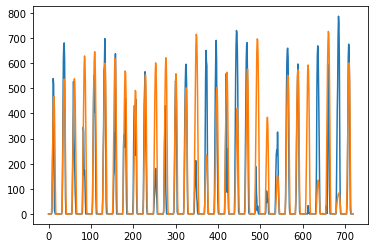

In [160]:
plt.plot(answer_df.loc[:,"dangjin"])
plt.plot(result.loc[:,"dangjin"])

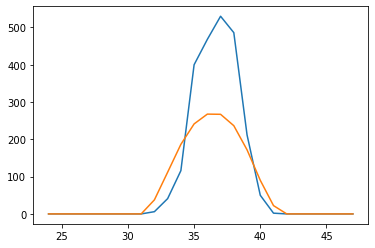

In [168]:
plt.plot(answer_df[answer_df["time"].dt.date == pd.Timestamp('2021-01-02')]["dangjin_floating"])
plt.plot(result[result["time"].dt.date == pd.Timestamp('2021-01-02')]["dangjin_floating"])

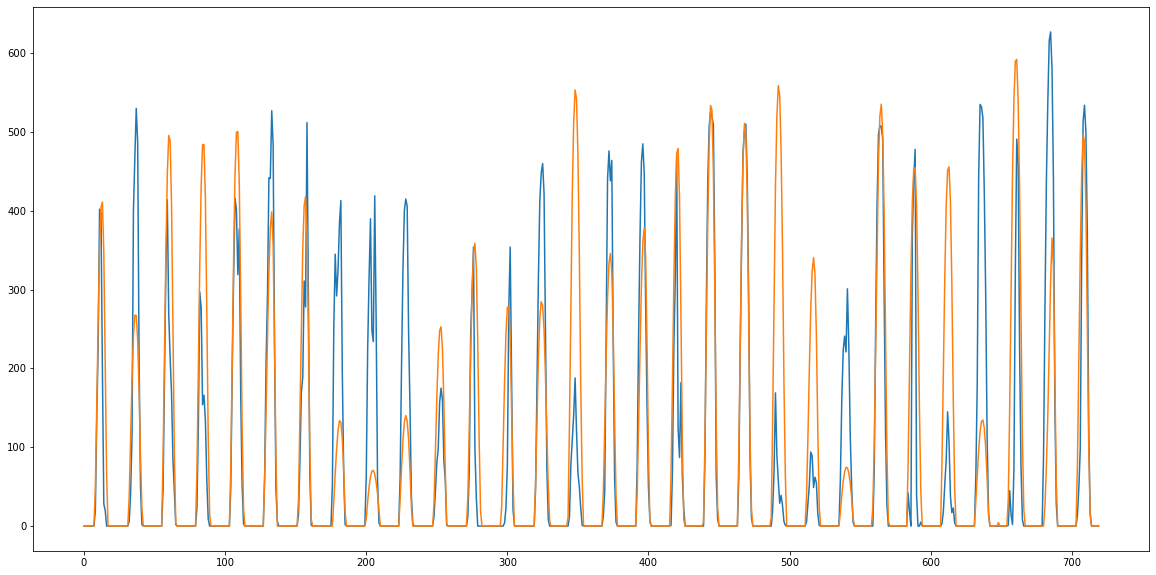

In [163]:
plt.figure(figsize = (20,10))
plt.plot(answer_df.loc[:,"dangjin_floating"])
plt.plot(result.loc[:,"dangjin_floating"])

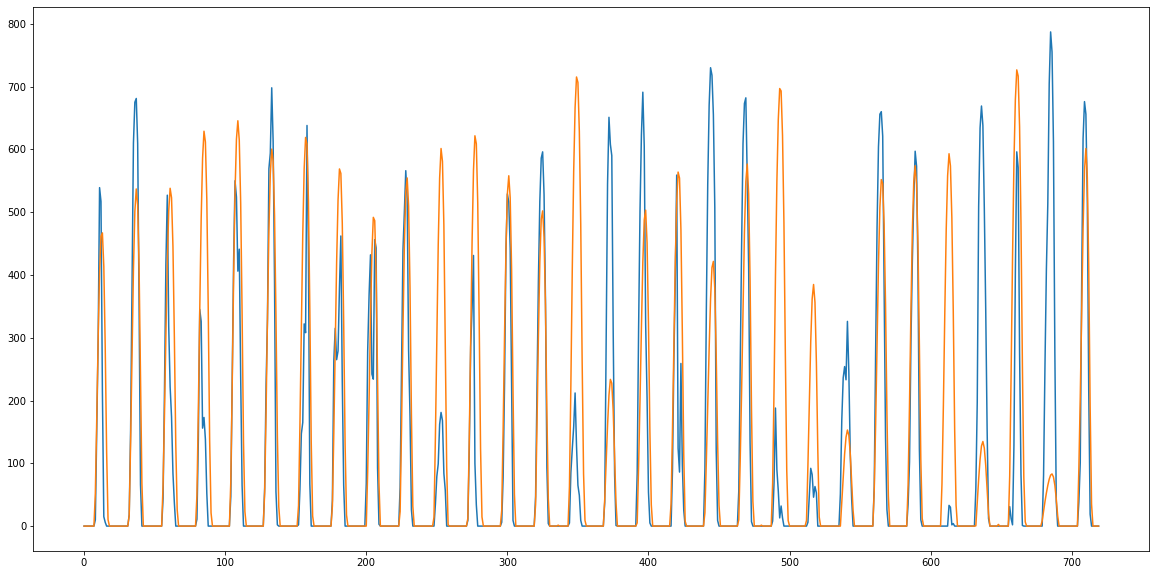

In [164]:
plt.figure(figsize = (20,10))
plt.plot(answer_df.loc[:,"dangjin"])
plt.plot(result.loc[:,"dangjin"])

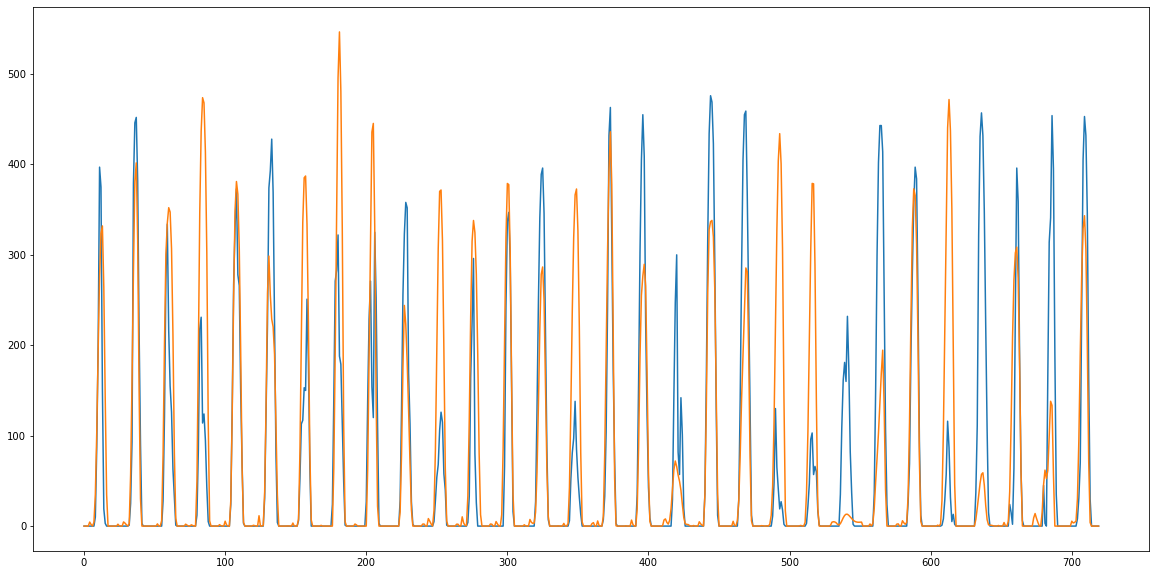

In [165]:
plt.figure(figsize = (20,10))
plt.plot(answer_df.loc[:,"dangjin_warehouse"])
plt.plot(result.loc[:,"dangjin_warehouse"])

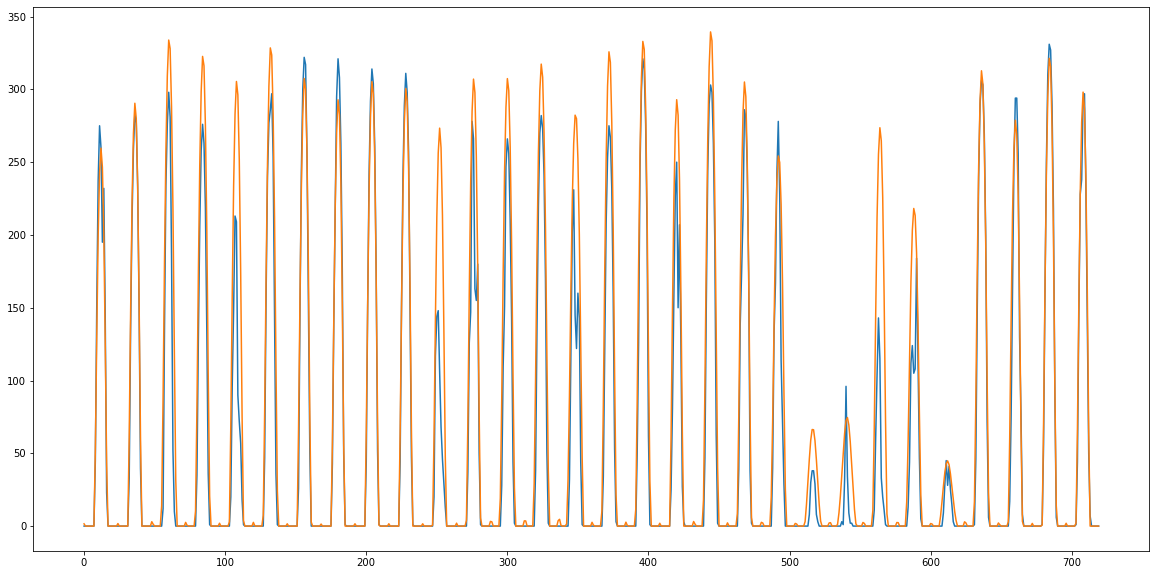

In [166]:
plt.figure(figsize = (20,10))
plt.plot(answer_df.loc[:,"ulsan"])
plt.plot(result.loc[:,"ulsan"])

# 6. Submission

In [ ]:
def zero_replacer(x):
    x[x < 0] = 0
    
    return x

In [74]:
#LightGBM

submission_dangjin = dangjin_fcst[(dangjin_fcst["time"] > '2020-02-01') & (dangjin_fcst["time"] < '2020-03-01')]

submission_dangjin = submission_dangjin.drop(["WindDirection"], axis = 1)

submission_ulsan = ulsan_fcst[(ulsan_fcst["time"] > '2020-02-01') & (ulsan_fcst["time"] < '2020-03-01')]

submission_ulsan = submission_ulsan.drop(["WindDirection"], axis = 1)

result = DataFrame([Models_dangjin.predict(submission_dangjin.iloc[:,1:]),
          Models_dangjin_warehouse.predict(submission_dangjin.iloc[:,1:]),
          Models_dangjin_floating.predict(submission_dangjin.iloc[:,1:]),
          Models_ulsan.predict(submission_ulsan.iloc[:,1:])]).T

result.columns = ["dangjin","dangjin_warehouse","dangjin_floating","ulsan"]

result = result[["dangjin_floating","dangjin_warehouse","dangjin","ulsan"]]

submission = pd.read_csv("data/sample_submission.csv")

result = result.apply(lambda x : zero_replacer(x))

submission.iloc[0:695,1] = result.iloc[:,0]
submission.iloc[0:695,2] = result.iloc[:,1]
submission.iloc[0:695,3] = result.iloc[:,2]
submission.iloc[0:695,4] = result.iloc[:,3]

submission.to_csv("submission.csv", index = False)

In [206]:
energy_fcst_ulsan

,num,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,Temperature,Humidity,WindSpeed,WindDirection,Cloud,day_night,month,year,day,hour,date
0,1067,2018-03-02 00:00:00,0.0,0.0,0,0,2.758622,28.868616,-1.754513,296.178762,1.582083,0.0,3.0,0.0,2.0,0.0,2018-03-02
1,1067,2018-03-02 01:00:00,0.0,0.0,0,0,2.624791,28.680616,-2.616446,281.857569,1.612726,0.0,3.0,0.0,2.0,1.0,2018-03-02
2,1067,2018-03-02 02:00:00,0.0,0.0,0,0,2.557080,28.578482,-3.332783,263.167052,1.643103,0.0,3.0,0.0,2.0,2.0,2018-03-02
3,1067,2018-03-02 03:00:00,0.0,0.0,0,0,2.555487,28.562213,-3.903523,240.107211,1.673213,0.0,3.0,0.0,2.0,3.0,2018-03-02
4,1067,2018-03-02 04:00:00,0.0,0.0,0,0,2.620012,28.631809,-4.328667,212.678046,1.703056,0.0,3.0,0.0,2.0,4.0,2018-03-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25531,2130,2021-01-31 19:00:00,0.0,0.0,0,0,10.049707,54.215463,3.288448,196.369194,2.280903,1.0,1.0,3.0,31.0,19.0,2021-01-31
25532,2130,2021-01-31 20:00:00,0.0,0.0,0,0,10.084327,57.238509,3.379024,201.536737,2.279816,0.0,1.0,3.0,31.0,20.0,2021-01-31
25533,2130,2021-01-31 21:00:00,0.0,0.0,0,0,9.000000,60.000000,3.500000,204.000000,4.000000,0.0,1.0,3.0,31.0,21.0,2021-01-31
25534,2130,2021-01-31 22:00:00,0.0,0.0,0,0,10.224648,60.729591,3.582716,202.931130,2.277357,0.0,1.0,3.0,31.0,22.0,2021-01-31


In [181]:
#LSTM

submission_dangjin = energy_fcst_dangjin[(energy_fcst_dangjin["time"] > '2020-01-31 23:00:00') & (energy_fcst_dangjin["time"] < '2020-03-01')]
submission_ulsan =  energy_fcst_ulsan[(energy_fcst_ulsan["time"] > '2020-01-31 23:00:00') & (energy_fcst_ulsan["time"] < '2020-03-01')]

submission_dangjin = np.stack(submission_dangjin.loc[:,["num","Temperature","Humidity","WindSpeed","Cloud","month","year","day","hour"]].groupby("num").apply(lambda x : np.array(x)))
submission_ulsan = np.stack(submission_ulsan.loc[:,["num","Temperature","Humidity","WindSpeed","Cloud","month","year","day","hour"]].groupby("num").apply(lambda x : np.array(x)))

result = DataFrame([

np.hstack(np.squeeze(Models_dangjin(submission_dangjin[:,:,1:]))) * ( 
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,
    
np.hstack(np.squeeze(Models_dangjin_warehouse(submission_dangjin[:,:,1:]))) * (
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,

np.hstack(np.squeeze(Models_dangjin_floating(submission_dangjin[:,:,1:]))) * (
    train_max_dangjin - train_min_dangjin) + train_min_dangjin,

    np.hstack(np.squeeze(Models_ulsan(submission_ulsan[:,:,1:]))) * (
    train_max_ulsan - train_min_ulsan) + train_min_ulsan]).T

result.columns = ["dangjin","dangjin_warehouse","dangjin_floating","ulsan"]

result = result[["dangjin_floating","dangjin_warehouse","dangjin","ulsan"]]

submission = pd.read_csv("data/sample_submission.csv")

result = result.apply(lambda x : zero_replacer(x))

submission.iloc[0:695,1] = result.iloc[:,0]
submission.iloc[0:695,2] = result.iloc[:,1]
submission.iloc[0:695,3] = result.iloc[:,2]
submission.iloc[0:695,4] = result.iloc[:,3]

submission.to_csv("submission.csv", index = False)

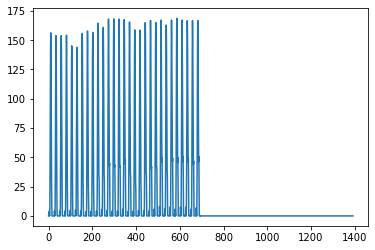

In [211]:
plt.plot(submission.iloc[:,2])